# DC-《野蛮时代》用户氪金预测分析

**项目背景**

移动互联网的崛起改变了游戏行业的面貌，从之前的街机、掌机psp发展到PC端游戏，现在手游已经成为人们最热爱的游戏形式，与之对应的游戏盈利模型的改变，从之前的线下售卖游戏版权、游戏时长(点卡)，到现在的游戏免费下载但是增值服务花样百出，对于手游来说，用户氪金已经成为了游戏公司重要的盈利来源之一，本项目针对《野蛮时代》这款SLG游戏进行用户氪金行为分析以及用户氪金金额预测。

本项目分为两部分，第一部分为对用户的游玩行为和氪金行为进行探索性分析，第二部分为基于用户前7天的氪金数据和行为，对45天用户是否氪金、氪金金额进行分类与回归预测


**探索性分析：游戏用户行为数据的深度探索**
- 1. 导入数据，了解数据基本信息<br>
    1.1 理解SLG游戏数据的特征<br>
    1.2 缺失/重复值<br>
- 2. 标签的探索：游戏经营的重要指标与经营现状<br>
- 3. 特征的探索<br>
    3.1 在线时长：用户是否以超出常规的速度流失？<br>
    3.2 分布与偏度：游戏对新手友好吗？游戏难度设置是否合理？<br>
    3.3 游戏平衡性：氪金对战斗系统的影响<br>
    3.4 左偏带来长尾：谁是异常玩家？<br>


**模型构筑：从0实现用户氪金行为预测**
- 1. 导库、整合数据<br>
- 2. 数据预处理：注册时间与氪金状况的关联<br>
- 3. 模型选择，建立模型benchmark<br>
- 4. 特征工程(1)：根据业务模式新增特征<br>
    4.1 新增业务指标新增特征<br>
    4.2 根据业务结论新增特征<br>
- 5. 特征工程(2)：达成建模所需的统计假设<br>
    5.1 相关性分析：筛选特征/特征重要性<br>
    5.2 训练/测试集分割的调优<br>
    5.3 异常值处理<br>
    5.4 归一化处理<br>
    5.5 正态化处理<br>
- 6. 模型融合：处理极度偏态、异常以及数据量带来的问题<br>
- 7. 模型调优<br> 

# 用户行为探索性分析

### 1. 导入数据，了解数据基本信息

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei'] #让jupyter中的图画上的中文都显示出来
plt.rcParams['axes.unicode_minus']=False

import sklearn
import time
import datetime

In [5]:
data = pd.read_csv(r"tap_fun_train.csv")

In [6]:
data.head() #查看数据的大致内容

,user_id,register_time,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
0,1,2018-02-02 19:47:15,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
1,1593,2018-01-26 00:01:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
2,1594,2018-01-26 00:01:58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1.166667,0.0,0,0.0
3,1595,2018-01-26 00:02:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,3.166667,0.0,0,0.0
4,1596,2018-01-26 00:02:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2.333333,0.0,0,0.0


#### 查看样本数/特征数

In [7]:
data.shape #109个特征中，第一列为玩家ID，最后一列为标签45日付费金额，因此实际特征量为107个特征

(2288007, 109)

#### 更换列名为中文

In [8]:
column_name = pd.read_excel(r"tap4fun 数据字段解释.xlsx")

In [9]:
column_name.head()

,字段名,字段解释,数据时间,变量性质,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,user_id,玩家唯一ID,永久,ID,目标：使用玩家在前7日的行为数据，预测玩家前45日付费金额。,NaN,NaN
1,register_time,玩家注册时间,永久,自变量,NaN,NaN,NaN
2,wood_add_value,木头获取数量,前七日,自变量,NaN,NaN,NaN
3,wood_reduce_value,木头消耗数量,前七日,自变量,NaN,NaN,NaN
4,stone_add_value,石头获取数量,前七日,自变量,NaN,NaN,NaN


In [10]:
data.columns

Index(['user_id', 'register_time', 'wood_add_value', 'wood_reduce_value',
       'stone_add_value', 'stone_reduce_value', 'ivory_add_value',
       'ivory_reduce_value', 'meat_add_value', 'meat_reduce_value',
       ...
       'pvp_battle_count', 'pvp_lanch_count', 'pvp_win_count',
       'pve_battle_count', 'pve_lanch_count', 'pve_win_count',
       'avg_online_minutes', 'pay_price', 'pay_count', 'prediction_pay_price'],
      dtype='object', length=109)

In [11]:
data.columns = column_name["字段解释"]

In [12]:
data.head()

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
0,1,2018-02-02 19:47:15,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
1,1593,2018-01-26 00:01:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
2,1594,2018-01-26 00:01:58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1.166667,0.0,0,0.0
3,1595,2018-01-26 00:02:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,3.166667,0.0,0,0.0
4,1596,2018-01-26 00:02:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2.333333,0.0,0,0.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288007 entries, 0 to 2288006
Columns: 109 entries, 玩家唯一ID to 45日付费金额
dtypes: float64(13), int64(95), object(1)
memory usage: 1.9+ GB


In [13]:
#看看完整的特征列表
data.columns.tolist()

['玩家唯一ID',
 '玩家注册时间',
 '木头获取数量',
 '木头消耗数量',
 '石头获取数量',
 '石头消耗数量',
 '象牙获取数量',
 '象牙消耗数量',
 '肉获取数量',
 '肉消耗数量',
 '魔法获取数量',
 '魔法消耗数量',
 '勇士招募数量',
 '勇士损失数量',
 '驯兽师招募数量',
 '驯兽师损失数量',
 '萨满招募数量',
 '萨满损失数量',
 '勇士伤兵产生数量',
 '勇士伤兵恢复数量',
 '驯兽师伤兵产生数量',
 '驯兽师伤兵恢复数量',
 '萨满伤兵产生数量',
 '萨满伤兵恢复数量',
 '通用加速获取数量',
 '通用加速使用数量',
 '建筑加速获取数量',
 '建筑加速使用数量',
 '科研加速获取数量',
 '科研加速使用数量',
 '训练加速获取数量',
 '训练加速使用数量',
 '治疗加速获取数量',
 '治疗加速使用数量',
 '建筑：士兵小屋等级',
 '建筑：治疗小井等级',
 '建筑：要塞等级',
 '建筑：据点传送门等级',
 '建筑：兵营等级',
 '建筑：治疗之泉等级',
 '建筑：智慧神庙等级',
 '建筑：联盟大厅等级',
 '建筑：仓库等级',
 '建筑：瞭望塔等级',
 '建筑：魔法幸运树等级',
 '建筑：战争大厅等级',
 '建筑：联盟货车等级',
 '建筑：占卜台等级',
 '建筑：祭坛等级',
 '建筑：冒险传送门等级',
 '科研：侦查等级',
 '科研：训练速度等级',
 '科研：守护者',
 '科研：巨兽驯兽师',
 '科研：吟唱者',
 '科研：勇士攻击',
 '科研：驯兽师攻击',
 '科研：萨满攻击',
 '科研：战斗大师',
 '科研：高阶巨兽骑兵',
 '科研：图腾大师',
 '科研：部队防御',
 '科研：勇士防御',
 '科研：驯兽师防御',
 '科研：萨满防御',
 '科研：勇士生命',
 '科研：驯兽师生命',
 '科研：萨满生命',
 '科研：狂战士',
 '科研：龙骑兵',
 '科研：神谕者',
 '科研：部队攻击',
 '科研：建造速度',
 '科研：资源保护',
 '科研：部队消耗',
 '科研：木材生产',
 '科研：石头生产',
 '科研：象牙生产',
 '科研：肉类生产',
 '科研：木材采集',
 '科研：石头采集',


- 数据中包括了大量可获得的资源（也可消耗）、可能达到的等级、可能获得的道具、可能获得的技能等特征，**在之后的课程中，我们统称所有的资源/等级/道具/技能等特征为资源**。
- 值得一提的是，除了最后的标签“45日付费金额”之外，**所有特征都是用户在服前7日**或与时间无关的数据（如用户ID）。

- 数据量巨大，以至于info函数都无法显示出缺失值情况<br>
- 1列数据是对象类型，也就是注册时间。<br>
- 有95列的数据类型都为整数，这需要注意。通常来说，当一个结构化数据中的特征数据类型是整数时，可以认为该特征可能是离散型特征<br>
- 但从游戏业务的独特性、以及特征含义来看，资源数量/等级/发起PVP次数等信息一般不会以浮点数表示，因此显示为整数也十分正常<br>
- 从特征含义来看，该数据集中没有任何离散型特征<br>

#### 检查是否存在缺失值/重复值

In [15]:
data.isnull().sum().sum() #不存在缺失值

0

In [16]:
data.duplicated().sum() #不存在重复值

0

In [17]:
data["玩家唯一ID"].duplicated().sum() #查看是否有重复ID的两种记录

0

#### 查看分布和统计信息

In [18]:
data.describe().T #查看分布和基本统计信息，其中25%，50%，75%分别代表1/4，1/2和3/4分位数

,count,mean,std,min,25%,50%,75%,max
字段解释,,,,,,,,
玩家唯一ID,2288007.0,1.529543e+06,9.399393e+05,1.0,749992.5,1.419095e+06,2.299006e+06,3.190530e+06
木头获取数量,2288007.0,4.543069e+05,4.958667e+06,0.0,0.0,4.203800e+04,1.531180e+05,1.239962e+09
木头消耗数量,2288007.0,3.698433e+05,3.737720e+06,0.0,0.0,9.830000e+03,9.855700e+04,7.995875e+08
石头获取数量,2288007.0,1.897788e+05,4.670620e+06,0.0,0.0,0.000000e+00,0.000000e+00,1.214869e+09
石头消耗数量,2288007.0,1.376074e+05,3.370166e+06,0.0,0.0,0.000000e+00,0.000000e+00,7.962378e+08
象牙获取数量,2288007.0,8.075623e+04,2.220540e+06,0.0,0.0,0.000000e+00,0.000000e+00,5.744961e+08
象牙消耗数量,2288007.0,3.613170e+04,1.782499e+06,0.0,0.0,0.000000e+00,0.000000e+00,4.481972e+08
肉获取数量,2288007.0,5.855155e+05,5.868629e+06,0.0,0.0,3.458700e+04,1.360010e+05,1.470644e+09
肉消耗数量,2288007.0,3.548102e+05,3.400632e+06,0.0,0.0,6.470000e+03,6.605400e+04,8.889537e+08


- 7日可以积攒的游戏资源量过亿，游戏本身可能被定为成低成本捞金游戏
- 游戏资源数据往往都是正偏的，因为大于50%的新增用户会在第二天就流失掉，因此大部分用户所掌握的资源量都很少。
- 然而现在的数据正偏的程度过高，最典型的，对于“石头”这样明显是基础资源的特征来说，位于上四分位数的值依然是0，至少有75%的玩家没有坚持到开采出木头以外的资源，玩家流失情况可能比我们想象得要严重很多，稍后可以深入探索一下
- 高度偏态的信息不利于异常值检测，可以预见大量的长尾数据会被归为异常值

### 2. 标签的探索：游戏经营的重要指标与经营现状

In [19]:
data.columns

Index(['玩家唯一ID', '玩家注册时间', '木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量',
       '象牙消耗数量', '肉获取数量', '肉消耗数量',
       ...
       'PVP次数', '主动发起PVP次数', 'PVP胜利次数', 'PVE次数', '主动发起PVE次数', 'PVE胜利次数',
       '在线时长', '付费金额', '付费次数', '45日付费金额'],
      dtype='object', name='字段解释', length=109)

In [20]:
y = data.iloc[:,-1] #最后一列：45日时的付费金额
SevenDayPayAmount = data.loc[:,"付费金额"] #另外也想探索一下7天内的经营状况

In [21]:
y

0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
5          0.00
6          0.00
7          0.00
8          0.00
9          0.00
10         0.00
11         0.00
12         0.00
13         0.00
14         0.00
15         0.00
16         0.00
17         0.00
18         0.00
19         0.00
20         0.00
21         0.00
22         0.00
23         0.00
24         0.00
25         0.99
26         0.00
27         0.00
28         0.00
29         0.00
           ... 
2287977    0.00
2287978    0.00
2287979    0.00
2287980    0.00
2287981    0.00
2287982    0.00
2287983    0.00
2287984    1.98
2287985    0.00
2287986    0.00
2287987    0.00
2287988    0.00
2287989    0.00
2287990    0.00
2287991    0.00
2287992    0.00
2287993    0.00
2287994    0.00
2287995    0.00
2287996    0.00
2287997    0.00
2287998    0.00
2287999    0.00
2288000    0.00
2288001    0.00
2288002    0.00
2288003    0.00
2288004    0.00
2288005    0.00
2288006    0.00
Name: 45日付费金额, Length: 2

In [22]:
#分布探索
y.describe([0.75,0.9,0.99]) #游戏中常有10%的付费用户养全服的情况，因此添加0.9及0.99两个选项

count    2.288007e+06
mean     1.793146e+00
std      8.846303e+01
min      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
90%      0.000000e+00
99%      3.970000e+00
max      3.297781e+04
Name: 45日付费金额, dtype: float64

从分布来看接近99%的用户都没有付费，游戏转化可能存在大问题

In [23]:
def RevenueFocus(RevenueSeries):
    #用于展示7日与45日氪金情况的关键指标
    #RevenueSeries只能是Series结构
    
    #中间变量
    AllUsers = len(RevenueSeries) #全部用户
    PaidUsers = (RevenueSeries != 0).sum() #付费用户量
    TotalPayment = RevenueSeries.sum() #总付费金额
    
    #打印结果
    print("付费率：{:.3f}%".format(100*PaidUsers/AllUsers))
    print("付费人数：{}".format(PaidUsers))
    print("转化总金额：{:.3f}".format(TotalPayment))
    print("ARPU：{:.3f}".format(TotalPayment/AllUsers)) #ARPU:Average Revenue Per User 用户平均收入
    print("ARPPU：{:.3f}".format(TotalPayment/PaidUsers)) #ARPPU: Average Revenue Per Paying User 付费用户平均收入
    print("前500高氪用户金额占比：{:.3f}%".format(100*RevenueSeries.sort_values(ascending=False)[:500].sum()/TotalPayment))
    print("前1000高氪用户金额占比：{:.3f}%".format(100*RevenueSeries.sort_values(ascending=False)[:1000].sum()/TotalPayment))
    print("前5000高氪用户金额占比：{:.3f}%".format(100*RevenueSeries.sort_values(ascending=False)[:5000].sum()/TotalPayment))

In [24]:
#45日转化情况
RevenueFocus(y)

付费率：2.010%
付费人数：45988
转化总金额：4102730.110
ARPU：1.793
ARPPU：89.213
前500高氪用户金额占比：51.618%
前1000高氪用户金额占比：64.878%
前5000高氪用户金额占比：89.375%


In [25]:
5000/data.shape[0]

0.002185307999494757

In [26]:
#7日转化情况
RevenueFocus(SevenDayPayAmount)

付费率：1.811%
付费人数：41439
转化总金额：1223326.660
ARPU：0.535
ARPPU：29.521
前500高氪用户金额占比：45.211%
前1000高氪用户金额占比：57.231%
前5000高氪用户金额占比：83.002%


- 整体来看付费率是**偏低**的，2016年时全球F2P(free to play)手游的付费率就有2.3%，《野蛮时代》的制作公司Tap4fun具有丰富的SLG手游经验，并且在开服测试阶段就有200w用户数据，转化率应该更高。2020年SLG手游的平均付费率大约在5%左右，顶级手游的付费率能够接近15%。（另外，在流量昂贵的现在，一个月400w的收入，或许还不能覆盖掉200w用户的流量成本，收入状况不算特别理想）

In [27]:
#7-45日新增付费用户数
45988 - 41439

4549

In [28]:
(SevenDayPayAmount == 0).sum() #前7天没有氪金的用户

2246568

In [29]:
#7-45日新增付费用户占7日前未氪金用户的占比
100*(45988 - 41439)/(SevenDayPayAmount == 0).sum()

0.2024866373953515

- 从数据逻辑来看，45日总付费不为0的用户一定包括前7日内付过费的用户。从7日到45日，新增付费用户仅有4549人（占不氪金用户的0.2%），即是说如果**一个新玩家在服的前七天没有氪金，那他/她在未来一个月内99.8%的可能性都不会氪金**。这可能时由于如下原因导致的：
> 1. 所有的用户都留存到了45日之后，这说明新用户福利过去后，游戏中的转化手段非常贫瘠，转化刺激严重不足
> 2. 大部分用户在45日之前已经流失，因此才没有继续转化为氪金用户的机会

计算7日之后再也没有付费的用户：

In [30]:
#7日之后再也没有付费的用户
#即，45日时付费金额与7日付费金额相同、且7日时付过费的用户

In [31]:
SevenDayPayAmount[SevenDayPayAmount == y] #筛选除了7天付费金额与45天付费金额一致的用户

0          0.00
1          0.00
2          0.00
3          0.00
4          0.00
5          0.00
6          0.00
7          0.00
8          0.00
9          0.00
10         0.00
11         0.00
12         0.00
13         0.00
14         0.00
15         0.00
16         0.00
17         0.00
18         0.00
19         0.00
20         0.00
21         0.00
22         0.00
23         0.00
24         0.00
25         0.99
26         0.00
27         0.00
28         0.00
29         0.00
           ... 
2287977    0.00
2287978    0.00
2287979    0.00
2287980    0.00
2287981    0.00
2287982    0.00
2287983    0.00
2287984    1.98
2287985    0.00
2287986    0.00
2287987    0.00
2287988    0.00
2287989    0.00
2287990    0.00
2287991    0.00
2287992    0.00
2287993    0.00
2287994    0.00
2287995    0.00
2287996    0.00
2287997    0.00
2287998    0.00
2287999    0.00
2288000    0.00
2288001    0.00
2288002    0.00
2288003    0.00
2288004    0.00
2288005    0.00
2288006    0.00
Name: 付费金额, Length: 2272

In [32]:
SevenDayPayAmount[SevenDayPayAmount == y][SevenDayPayAmount != 0].count()

30130

In [33]:
#占前7天总付费人数的占比
100*30130/41439

72.70928352518159

不难发现，7日之前付过费，并且7日之后再也没有付费的用户有3万多人，占到前7天总付费用户的72%，**即一个新玩家在服前七天有氪金，但她/他在未来一个月还是有7成的概率不再继续氪金**。这可能说明（按可能性排序）：
> 1. 对大部分用户而言，最初氪的是超低价/超实惠新手礼包，后续氪金礼包中的福利/以及价格超出了大部分用户对游戏氪金的心理预期
> 2. 新手礼包力度过大，导致后续氪金礼包中的福利看起来不够实惠，用户再付费门槛较高
> 3. 游戏本身粘性不足，无论用户是否氪金，大部分人都在7-45日内自然流失了（甚至在前7日就流失了大部分）
> 4. 开局需要发育时玩家更愿意氪金解决问题（痒感充足），发育起来之后便不再具有强烈氪金需求/发育不起来直接退服了
> 5. （可能性较小，仅针对少部分前7日巨氪但7日后却不再氪的大佬）氪金后体验一般甚至较差，例如，发现氪几百、上千元后对玩家竞争力无明显提升

In [34]:
#7日后再也没有付过费的用户前7日的氪金概况
SevenDayPayAmount[SevenDayPayAmount == y][SevenDayPayAmount != 0].describe()

count    30130.000000
mean        11.407407
std         71.134875
min          0.990000
25%          0.990000
50%          1.980000
75%          5.980000
max       4086.520000
Name: 付费金额, dtype: float64

In [35]:
SevenDayPayAmount[SevenDayPayAmount == y][SevenDayPayAmount != 0].sum()

343705.17000000004

In [36]:
#7日后继续付费的用户前7日的氪金概况
SevenDayPayAmount[SevenDayPayAmount != y][SevenDayPayAmount != 0].describe()

count    11309.000000
mean        77.780661
std        289.610458
min          0.990000
25%          2.980000
50%         15.970000
75%         45.940000
max       7457.950000
Name: 付费金额, dtype: float64

In [37]:
SevenDayPayAmount[SevenDayPayAmount != y][SevenDayPayAmount != 0].sum()

879621.4900000001

In [38]:
#7日后继续付费的用户在45日时的氪金概况
y[SevenDayPayAmount != y][SevenDayPayAmount != 0].describe()

count    11309.000000
mean       315.963475
std       1202.828424
min          1.980000
25%         16.940000
50%         48.920000
75%        163.760000
max      32977.810000
Name: 45日付费金额, dtype: float64

从以上数据可以看出，7日后继续氪金的玩家在前7日会氪更多的金额，7日后不再氪金的玩家中有75%都只氪了6元以下的金额，而7日后继续氪金的玩家中有50%以上都磕了16元左右，这极大地印证了我们提出的第一条理由：大部分人氪新手礼包，而后续礼包的价格在大部分人的心理预期之外。同时，7日后不再氪金的玩家中也有不少氪过百过千的玩家，最终放弃游戏可能是因为自然流失/氪金后体验不足以满足部分用户的想象。但从7日后继续付费的用户氪金情况来看，用户是倾向于越氪越多的，因此大部分用户对于氪金后的感受应该是满意的。（后续我们会看到，结合ARPU和ARPPU的数据，可以推测氪金后的游戏体验是很不错的）。

In [39]:
#使用箱线图来对比两类用户在前7日的氪金情况

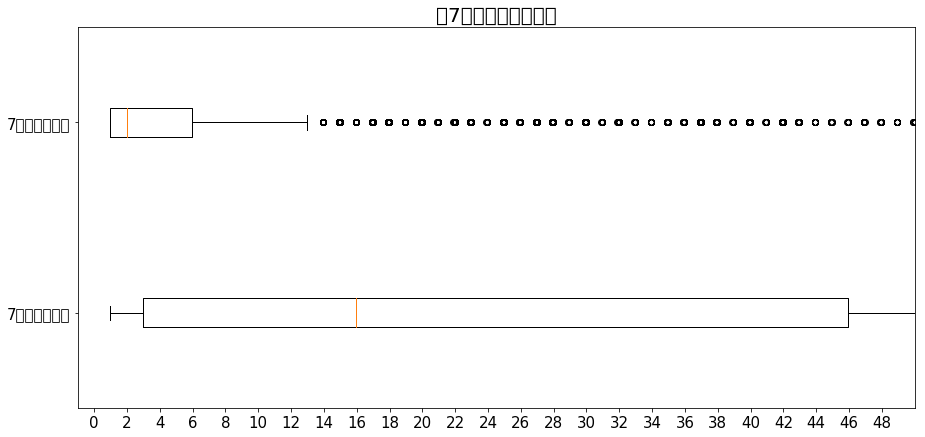

In [42]:
plt.figure(figsize=(15,7))
plt.boxplot([SevenDayPayAmount[SevenDayPayAmount != y][SevenDayPayAmount != 0],SevenDayPayAmount[SevenDayPayAmount == y][SevenDayPayAmount != 0]],labels=["7日后继续付费","7日后不再付费"],vert=False,showmeans=False)
plt.xlim(-1,50)
plt.title('前7日消费金额分布图',fontsize=20.0)
plt.yticks(fontsize=15.0)
plt.xticks(range(0,50,2),fontsize=15.0)
#plt.vlines(6.0,ymin = plt.ylim()[0]+0.1,ymax = plt.ylim()[1]-0.1,colors="red",linestyles="dotted")
plt.show()

不难发现，氪金的范围虽然一样，但继续付费用户的分布要靠右许多，说明7日后付费用户在前7日消费更多。

考虑到后续付费用户有50%都付了16元及以上，我们推测这个金额点应该是在16元以下的，因此我们设置潜在金额的范围为1-16。

In [43]:
PotentialPoints = range(1,16)

In [44]:
for i in PotentialPoints:
    #取出所有7天内付费金额超出i的付费用户
    HigherThanPoint = SevenDayPayAmount[SevenDayPayAmount>=i] 
    #这些用户中，继续付费的用户所占的比例
    KeepPaid = len(HigherThanPoint[SevenDayPayAmount != y])/len(HigherThanPoint) 
    #这些用户中，停止付费的用户所占的比例，其实就是1-KeepPaid
    StopPaid = len(HigherThanPoint[SevenDayPayAmount == y])/len(HigherThanPoint)
    print(i)
    print("{:.3f}%".format(100*KeepPaid))
    print("{:.3f}%".format(100*StopPaid))
    print("{:.3f}%".format(KeepPaid - StopPaid))
    if KeepPaid - StopPaid > 0:
        print("当7日内付费金额大于{:.2f}时，用户继续氪金的可能性比不再氪金的可能性更高！".format(i))
        break

1
37.683%
62.317%
-0.246%
2
43.720%
56.280%
-0.126%
3
45.759%
54.241%
-0.085%
4
46.532%
53.468%
-0.069%
5
48.094%
51.906%
-0.038%
6
50.778%
49.222%
0.016%
当7日内付费金额大于6.00时，用户继续氪金的可能性比不再氪金的可能性更高！


用图像来呈现则更加明显：

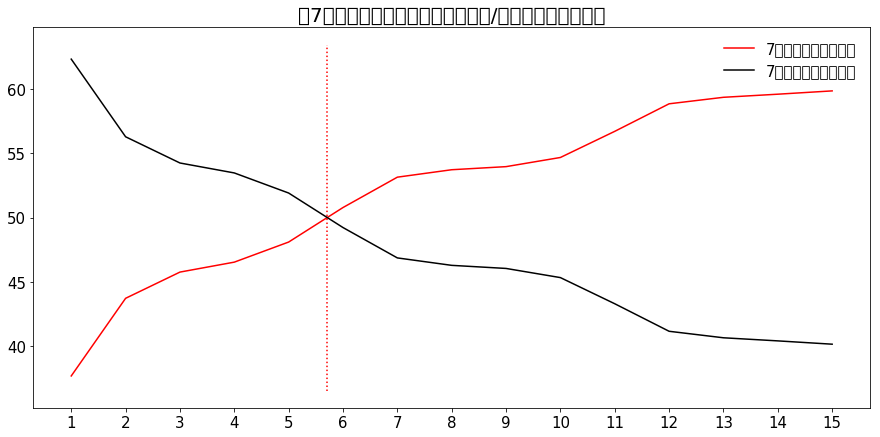

In [45]:
KeepPaidList = []
StopPaidList = []
for i in PotentialPoints:
    #取出所有7天内付费金额超出i的付费用户
    HigherThanPoint = SevenDayPayAmount[SevenDayPayAmount>=i] 
    #这些用户中，继续付费的用户所占的比例
    KeepPaid = len(HigherThanPoint[SevenDayPayAmount != y])/len(HigherThanPoint) 
    #这些用户中，停止付费的用户所占的比例
    StopPaid = len(HigherThanPoint[SevenDayPayAmount == y])/len(HigherThanPoint)
    KeepPaidList.append(100*KeepPaid)
    StopPaidList.append(100*StopPaid)

plt.figure(figsize=(15,7))
plt.plot(PotentialPoints,KeepPaidList,label="7日后继续付费的概率",color="red")
plt.plot(PotentialPoints,StopPaidList,label="7日后停止付费的概率",color="k")
#plt.xlim(-1,50)
plt.title('前7日氪金数额增加，继续付费概率/不再付费概率的变化',fontsize=20.0)
plt.yticks(fontsize=15.0)
plt.xticks(range(0,16,1),fontsize=15.0)
plt.legend(fontsize = 15.0, frameon = False)
plt.vlines(5.7,ymin = plt.ylim()[0]+0.1,ymax = plt.ylim()[1]-0.1,colors="red",linestyles="dotted")
plt.show()

 - <font color="#dd0000"> **高价值用户评判的第一个可能的标准：前7日氪金超过6元的用户是更有价值的用户**</font><br><br>
以此推测，新手礼包设置为5-7元，或许可以明确辨析出用户的付费能力。

在前7日内付费6元以下的用户，无论是否自然流失，未来氪金的可能性都是小于不再付费的可能性的。可以通过设置游戏体验，给与付费5元左右的用户更多的“刺激”，让他们后续继续付费。也可选择直接放弃6元以下的付费用户，体验维持现状或减少资源分配，让更多的资源/服务围绕更有可能付费的用户展开。

接下来是收入分析

In [46]:
#45日转化情况
RevenueFocus(y)

付费率：2.010%
付费人数：45988
转化总金额：4102730.110
ARPU：1.793
ARPPU：89.213
前500高氪用户金额占比：51.618%
前1000高氪用户金额占比：64.878%
前5000高氪用户金额占比：89.375%


In [47]:
y.max()

32977.81

In [48]:
#7日转化情况
RevenueFocus(SevenDayPayAmount)

付费率：1.811%
付费人数：41439
转化总金额：1223326.660
ARPU：0.535
ARPPU：29.521
前500高氪用户金额占比：45.211%
前1000高氪用户金额占比：57.231%
前5000高氪用户金额占比：83.002%


来看ARPU与ARPPU数据。ARPU是全服用户平均收入，ARPPU是全服付费用户平均收入，目前来看全服的ARPU较低，但ARPPU还不错，这说明虽然付费人数不多，但是大R（大人民币玩家）的付费能力相对较强。从前5000高氪用户金额占比来看，45日时全服氪金前5000的人(z占比小于0.22%)提供了全服89%的收入，大R们贡献巨大。这令我猜测，《野蛮时代》中的氪金行为应该与玩家竞争力有较为直接的联系，因为许多大R玩家非常偏爱强PK类游戏，付费可以直接让PVP变得异常简单，不过全服最氪玩家在一个月内的消费只有3w2，在SLG手游领域并非一个很高的数字，如果游戏体验优秀，应该还有很大的上升空间。而付费人数不多的问题还可以改善，游戏整体的经营成果还可以上一个台阶。

### 3. 特征的探索

#### 3.1 在线时长：用户是否以超出常规的速度流失？

In [49]:
data.columns

Index(['玩家唯一ID', '玩家注册时间', '木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量',
       '象牙消耗数量', '肉获取数量', '肉消耗数量',
       ...
       'PVP次数', '主动发起PVP次数', 'PVP胜利次数', 'PVE次数', '主动发起PVE次数', 'PVE胜利次数',
       '在线时长', '付费金额', '付费次数', '45日付费金额'],
      dtype='object', name='字段解释', length=109)

In [50]:
PlayTime = data.loc[:,"在线时长"]

In [51]:
PlayTime.max()

2049.666667

原数据并未说明这个衡量时间的特征的单位，但7日为168小时，因此该特征的单位应该是分钟。前7日内游戏时长最长的玩家玩了2049分钟，即34个小时，每日玩5个小时以上，也是铁杆玩家可以达得到的数据，单位为分钟是合理的。

In [52]:
pd.set_option("display.float_format", lambda x: "%.3f" % x) #避免显示问题，设置不显示科学计数法
PlayTime.describe()

count   2288007.000
mean         10.207
std          38.959
min           0.000
25%           0.500
50%           1.833
75%           4.833
max        2049.667
Name: 在线时长, dtype: float64

75%的人在前7日一共只玩了4.8分钟或以下，这是说超过75%的用户只是稍微看了一眼游戏就被劝退了。

In [53]:
PlayTime.describe(percentiles=[0.75,.9,0.95,.99]) #查看一下90%以上的分布

count   2288007.000
mean         10.207
std          38.959
min           0.000
50%           1.833
75%           4.833
90%          15.000
95%          41.333
99%         183.657
max        2049.667
Name: 在线时长, dtype: float64

SLG游戏天生会充满许多任务、奖励和剧情，除非用户登录即退出，否则登入一次至少应该停留5分钟以上，新用户停留的时间应当更长（有非常多的内容需要探索、任务列表也很长）。如果一个用户在注册游戏后第二天依然被留存下来、并参与到游戏当中，那两天在线时长至少也应该有15-20分钟。75%的用户在前7日内只玩了4.8分钟，而如下所示，90%的用户在7日内只玩了15分钟以下。据推断，大约只有10~15%的用户在第二天依然留存下来，同时每天大约玩10分钟，7日后依然留存下来的用户大约少于5%。用户的确以超出常规的方式流失，在这种流失方式下，付费率也很难被拯救。

In [54]:
#谁是这个玩了2049分钟的用户？

In [55]:
 (data["在线时长"] > 2000).sum() #可能测试人员，GM

1

In [56]:
data.loc[data["在线时长"] > 2049,:] #69木头获取，69w肉获取

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
488497,645487,2018-03-04 13:43:36,697852.000,300255.000,0.000,0.000,6000.000,0.000,690379.000,196602.000,...,5,0,0,2,2,2,2049.667,0.000,0,0.000


In [57]:
data.loc[data["在线时长"] > 1500,:] #比起时长，是否更加深度参与游戏或许才与氪金更相关

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
488497,645487,2018-03-04 13:43:36,697852.000,300255.000,0.000,0.000,6000.000,0.000,690379.000,196602.000,...,5,0,0,2,2,2,2049.667,0.000,0,0.000
1263615,1579134,2018-03-05 11:04:18,15722711.000,15269965.000,8895972.000,7952637.000,4554662.000,3025143.000,23321313.000,21071538.000,...,48,25,11,100,100,86,1674.667,2.980,2,514.680


In [58]:
#尝试查找氪金用户们前7日的游戏时间

In [59]:
PaidPlayTime = data.loc[data["付费金额"] != 0,"在线时长"]

In [60]:
PaidPlayTime.describe().T #只有25%以下的用户在线时间在半小时以下，游戏时间明显比非氪金用户多很多

count   41439.000
mean      140.188
std       149.973
min         0.000
25%        33.000
50%        88.833
75%       194.667
max      1674.667
Name: 在线时长, dtype: float64

In [61]:
#在线时长甚至不足1分钟的闭眼氪玩家们，有40人氪了0.99

In [62]:
data.loc[data["在线时长"]<=1,"付费金额"].value_counts()

0.000     896061
0.990         51
9.990          4
36.960         3
5.980          3
4.990          3
99.990         2
56.950         2
19.990         1
26.970         1
25.970         1
6.980          1
49.990         1
1.990          1
Name: 付费金额, dtype: int64

In [63]:
#在线时间很长的用户也不一定就是高氪大佬
#在线时间很短的用户也不一定就完全不氪
#如何就在线时间这个点来进行用户价值判断呢？

In [64]:
#在线时长很少的玩家们贡献的氪金数额
for playtime in [1,5,15,20,25,30]:
    
    MeanPay45 = data.loc[data["在线时长"]<playtime,"45日付费金额"].mean()
    TotalPay45 = data.loc[data["在线时长"]<playtime,"45日付费金额"].sum()
    MeanPay7 = data.loc[data["在线时长"]<playtime,"付费金额"].mean()
    TotalPay7 = data.loc[data["在线时长"]<playtime,"付费金额"].sum()
    
    print("一周在线时长不足{}分钟".format(playtime))
    print("\t45日平均消费额为{:.3f}元，45日总消费额为{:.3f}元".format(MeanPay45,TotalPay45))
    print("\t7日平均消费额为{:.3f}元，7日总消费额为{:.3f}元".format(MeanPay7,TotalPay7))
    print("\t7日氪金占比{:.3f}%，45日氪金占比{:.3f}%".format(100*TotalPay7/(data["付费金额"].sum())
                                                  ,100*TotalPay45/(data["45日付费金额"].sum())))

一周在线时长不足1分钟
	45日平均消费额为0.022元，45日总消费额为18323.490元
	7日平均消费额为0.001元，7日总消费额为574.180元
	7日氪金占比0.047%，45日氪金占比0.447%
一周在线时长不足5分钟
	45日平均消费额为0.019元，45日总消费额为32572.700元
	7日平均消费额为0.003元，7日总消费额为4519.280元
	7日氪金占比0.369%，45日氪金占比0.794%
一周在线时长不足15分钟
	45日平均消费额为0.028元，45日总消费额为57753.190元
	7日平均消费额为0.009元，7日总消费额为18428.260元
	7日氪金占比1.506%，45日氪金占比1.408%
一周在线时长不足20分钟
	45日平均消费额为0.038元，45日总消费额为79124.920元
	7日平均消费额为0.012元，7日总消费额为25904.310元
	7日氪金占比2.118%，45日氪金占比1.929%
一周在线时长不足25分钟
	45日平均消费额为0.044元，45日总消费额为94650.110元
	7日平均消费额为0.016元，7日总消费额为34217.390元
	7日氪金占比2.797%，45日氪金占比2.307%
一周在线时长不足30分钟
	45日平均消费额为0.050元，45日总消费额为107763.140元
	7日平均消费额为0.019元，7日总消费额为40862.200元
	7日氪金占比3.340%，45日氪金占比2.627%


不难发现，在线时长很少的玩家们贡献的氪金数额很少，在对200w人进行建模时，我们可以忽略一部分在线时间很短的用户。在这里，我们可以将一周在线时长不足15或20分钟的用户判断为低价值用户。

In [65]:
data["在线时长"].sort_values(ascending=False)[:2288] #最肝的前0.1%的用户的7日在线时长

488497    2049.667
1263615   1674.667
882241    1482.000
1558221   1452.333
1335561   1452.333
62992     1394.667
992862    1388.333
1158840   1383.167
1746227   1345.167
213886    1341.833
2112374   1330.667
1837738   1325.667
417755    1323.833
64686     1322.833
776433    1285.000
1763509   1276.667
2266680   1248.333
1219364   1247.333
1184770   1244.333
2153338   1238.333
1957221   1230.500
528092    1219.167
191989    1213.000
2264330   1211.167
1663872   1209.167
1967566   1187.833
949514    1174.833
782598    1174.333
999433    1174.333
1808100   1174.333
            ...   
362232     505.833
1133306    505.833
2231031    505.833
317627     505.667
470937     505.500
702426     505.333
2048176    505.167
1754395    505.167
1327108    505.167
1801066    505.167
420148     505.167
1643023    505.167
251957     505.000
1220040    505.000
1136641    505.000
1568059    505.000
935225     505.000
2080258    504.833
47954      504.833
976535     504.833
666284     504.833
793268     5

In [66]:
#在线时长超长的玩家们贡献的氪金数额
for playtime in [500,600,700,800,900,1000,1200]:
    
    MeanPay45 = data.loc[data["在线时长"]>=playtime,"45日付费金额"].mean()
    TotalPay45 = data.loc[data["在线时长"]>=playtime,"45日付费金额"].sum()
    MeanPay7 = data.loc[data["在线时长"]>=playtime,"付费金额"].mean()
    TotalPay7 = data.loc[data["在线时长"]>=playtime,"付费金额"].sum()
    
    print("一周在线时长超过{}分钟".format(playtime))
    print("\t45日平均消费额为{:.3f}元，45日总消费额为{:.3f}元".format(MeanPay45,TotalPay45))
    print("\t7日平均消费额为{:.3f}元，7日总消费额为{:.3f}元".format(MeanPay7,TotalPay7))
    print("\t7日氪金占比{:.3f}%，45日氪金占比{:.3f}%".format(100*TotalPay7/(data["付费金额"].sum())
                                                  ,100*TotalPay45/(data["45日付费金额"].sum())))

一周在线时长超过500分钟
	45日平均消费额为377.113元，45日总消费额为885839.060元
	7日平均消费额为110.492元，7日总消费额为259544.740元
	7日氪金占比21.216%，45日氪金占比21.591%
一周在线时长超过600分钟
	45日平均消费额为437.753元，45日总消费额为515673.070元
	7日平均消费额为130.699元，7日总消费额为153963.300元
	7日氪金占比12.586%，45日氪金占比12.569%
一周在线时长超过700分钟
	45日平均消费额为427.776元，45日总消费额为272921.300元
	7日平均消费额为120.904元，7日总消费额为77136.600元
	7日氪金占比6.305%，45日氪金占比6.652%
一周在线时长超过800分钟
	45日平均消费额为359.040元，45日总消费额为113815.780元
	7日平均消费额为104.344元，7日总消费额为33076.950元
	7日氪金占比2.704%，45日氪金占比2.774%
一周在线时长超过900分钟
	45日平均消费额为218.907元，45日总消费额为36557.400元
	7日平均消费额为43.819元，7日总消费额为7317.770元
	7日氪金占比0.598%，45日氪金占比0.891%
一周在线时长超过1000分钟
	45日平均消费额为139.194元，45日总消费额为12109.910元
	7日平均消费额为40.055元，7日总消费额为3484.820元
	7日氪金占比0.285%，45日氪金占比0.295%
一周在线时长超过1200分钟
	45日平均消费额为25.492元，45日总消费额为637.300元
	7日平均消费额为2.869元，7日总消费额为71.730元
	7日氪金占比0.006%，45日氪金占比0.016%


许多用户虽然深度参与游戏，但是“好肝不好氪”，所以过于肝的用户也不是高价值用户。我们可以规定，一周在线时长超出800分钟的用户为（氪金层面）低价值用户。同样的，氪金用户一般在资源上占绝对的主导，但是资源很多的用户不一定是氪金用户。

In [67]:
data.loc[data["付费金额"] != 0,"木头获取数量"].describe() #资源量上氪金用户站绝对的主导

count        41439.000
mean      10712783.554
std       34752584.812
min              0.000
25%        2132829.500
50%        5267091.000
75%       10249321.000
max     1239962311.000
Name: 木头获取数量, dtype: float64

In [68]:
data.loc[data["付费金额"] == 0,"木头获取数量"].describe()

count     2246568.000
mean       265084.447
std        887773.641
min             0.000
25%             0.000
50%         40088.000
75%        144657.000
max     158249380.000
Name: 木头获取数量, dtype: float64

In [69]:
data[data["木头获取数量"] == 158249380] #异常用户，非常牛的用户

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
2046401,2907550,2018-03-04 14:41:57,158249380.000,157202081.000,129870402.000,129357887.000,3000.000,0.000,69427801.000,68360181.000,...,282,0,0,2,1,1,125.000,0.000,0,0.000


不难发现，拥有众多资源、但在7日内却没有付费过的用户，是（氪金层面上）的低价值用户。

#### 3.2 分布与偏度：游戏是否对新手不友好？资源获取难度设置合理吗？

大量的特征都是严重正偏的（即大部分值集中在左侧，分布上的高峰偏左严重）。

In [70]:
#pd.set_option("display.max_rows",120) #避免显示问题，设置一下最大行数
data.describe().T

,count,mean,std,min,25%,50%,75%,max
字段解释,,,,,,,,
玩家唯一ID,2288007.000,1529543.498,939939.279,1.000,749992.500,1419095.000,2299006.500,3190530.000
木头获取数量,2288007.000,454306.859,4958667.146,0.000,0.000,42038.000,153118.000,1239962311.000
木头消耗数量,2288007.000,369843.252,3737720.038,0.000,0.000,9830.000,98557.000,799587506.000
石头获取数量,2288007.000,189778.774,4670619.517,0.000,0.000,0.000,0.000,1214869437.000
石头消耗数量,2288007.000,137607.363,3370166.356,0.000,0.000,0.000,0.000,796237770.000
象牙获取数量,2288007.000,80756.230,2220540.322,0.000,0.000,0.000,0.000,574496104.000
象牙消耗数量,2288007.000,36131.699,1782498.688,0.000,0.000,0.000,0.000,448197157.000
肉获取数量,2288007.000,585515.505,5868629.397,0.000,0.000,34587.000,136001.000,1470643810.000
肉消耗数量,2288007.000,354810.206,3400632.455,0.000,0.000,6470.000,66054.000,888953714.000


- **数据正偏说明游戏中拥有大量资源人较少，因为相比起中线，大部分人在资源/等级上都值离原点更近**。

**如果所有的用户都留存到7日之后，资源数据分布应该是接近正太分布**，现在已经知道用户在前7天是严重流失的，资源分布会左偏也合理，但为何用户会流失如此严重呢？可能从流量端开始就有问题（比如投放到了不太合适的流量渠道）、投放的广告可能有问题（比如让用户误以为是其他类型游戏），也可能是游戏美工不足、吸引力较低等方面（在75%的用户看一眼就被劝退的前提下，有理由相信游戏美工和流畅度有较大问题）。

除了上述理由，用户大量流失还可能是游戏对新手不太友好或者游戏平衡性严重受氪金影响导致的。如果游戏中资源获取很困难，比如大部分资源都需要较长的时间或氪金来进行积累（这可能是刺激氪金的策略：新手阶段不友好，游戏上手难度大），大部分玩家在10~15分钟内无法获得足够的刺激与获得感，那用户在半小时内流失的可能性就很高。我们可以尝试着观察几个资源层次的平均游戏时间，以此来判断游戏中的资源是否难以获得：

In [71]:
data["木头获取数量"].describe()

count      2288007.000
mean        454306.859
std        4958667.146
min              0.000
25%              0.000
50%          42038.000
75%         153118.000
max     1239962311.000
Name: 木头获取数量, dtype: float64

In [72]:
data.loc[data["木头获取数量"] > 1239962310,"在线时长"] #在线时长约10个小时，即每天玩1个多小时，一周即可获得木头资源过亿

1423324   697.333
Name: 在线时长, dtype: float64

In [73]:
data.loc[data["木头获取数量"] == 153118,"在线时长"].mean() #平均在线约3.75分钟即可获得15w木头

3.75

In [74]:
data.loc[data["木头获取数量"] == 42038,"在线时长"].mean() #平均在线1分钟即可获得4w2木头

1.2527109844413018

从结果来看，至少木头资源一点也不难获得，反而来得太容易了。在手游界，可以轻松拥有百万资源、上亿资源的游戏一般都不太高级。

那是否其他资源非常难以获得呢？在现有数据下，我们可以通过分析资源存量来分析游戏中资源获取难度分类的合理性。

资源的分布本身就可以帮助进行分析。由于数据量的缘故，无法对所有的特征都绘制分布图，但可以计算所有特征的偏度与峰度。

> 1. 偏度的中间值为0，正偏度则说明分布左偏，负偏度则说明分布右偏
> 2. 偏度值越大，则说明分布偏移得越厉害。例如，偏度远远大于0时，说明大部分数据都集中在原点附近。
> 3. 正态分布的峰度为3（和巨大峰度相比约等于0），大于3的峰度说明山峰陡峭，小于3的峰度说明山峰平缓
> 4. 峰度值越大，则说明数据的分布越不均匀、越集中于某些值。

对游戏数据而言，偏度与峰度衡量的内容是类似的：偏度说明分布对称的情况，峰度说明分布集中在少数点的情况，巨大的正偏态和巨大的峰度都指向“大部分玩家只能收集到很少资源/或无资源”的状态。结合单一资源的均值，我们可以进一步判断资源获取的真实情况。在这里，我们只衡量资源/技能等级，不衡量PVP次数等涉及到对战的因素。

In [75]:
data.columns

Index(['玩家唯一ID', '玩家注册时间', '木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量',
       '象牙消耗数量', '肉获取数量', '肉消耗数量',
       ...
       'PVP次数', '主动发起PVP次数', 'PVP胜利次数', 'PVE次数', '主动发起PVE次数', 'PVE胜利次数',
       '在线时长', '付费金额', '付费次数', '45日付费金额'],
      dtype='object', name='字段解释', length=109)

In [76]:
resource = data.iloc[:,2:-10]

In [77]:
resource.columns

Index(['木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量', '象牙消耗数量', '肉获取数量',
       '肉消耗数量', '魔法获取数量', '魔法消耗数量', '勇士招募数量', '勇士损失数量', '驯兽师招募数量', '驯兽师损失数量',
       '萨满招募数量', '萨满损失数量', '勇士伤兵产生数量', '勇士伤兵恢复数量', '驯兽师伤兵产生数量', '驯兽师伤兵恢复数量',
       '萨满伤兵产生数量', '萨满伤兵恢复数量', '通用加速获取数量', '通用加速使用数量', '建筑加速获取数量', '建筑加速使用数量',
       '科研加速获取数量', '科研加速使用数量', '训练加速获取数量', '训练加速使用数量', '治疗加速获取数量', '治疗加速使用数量',
       '建筑：士兵小屋等级', '建筑：治疗小井等级', '建筑：要塞等级', '建筑：据点传送门等级', '建筑：兵营等级',
       '建筑：治疗之泉等级', '建筑：智慧神庙等级', '建筑：联盟大厅等级', '建筑：仓库等级', '建筑：瞭望塔等级',
       '建筑：魔法幸运树等级', '建筑：战争大厅等级', '建筑：联盟货车等级', '建筑：占卜台等级', '建筑：祭坛等级',
       '建筑：冒险传送门等级', '科研：侦查等级', '科研：训练速度等级', '科研：守护者', '科研：巨兽驯兽师', '科研：吟唱者',
       '科研：勇士攻击', '科研：驯兽师攻击', '科研：萨满攻击', '科研：战斗大师', '科研：高阶巨兽骑兵', '科研：图腾大师',
       '科研：部队防御', '科研：勇士防御', '科研：驯兽师防御', '科研：萨满防御', '科研：勇士生命', '科研：驯兽师生命',
       '科研：萨满生命', '科研：狂战士', '科研：龙骑兵', '科研：神谕者', '科研：部队攻击', '科研：建造速度',
       '科研：资源保护', '科研：部队消耗', '科研：木材生产', '科研：石头生产', '科研：象牙生产', '科研：肉类生产',
       '科研：木材采集', '科研：石头采集', '科研

In [79]:
sak = pd.DataFrame()
for idx,ColName in enumerate(resource.columns):
    sak.loc[idx,"特征"] = ColName
    column = data.loc[:,ColName]
    sak.loc[idx,"偏度"] = column.skew() #偏度
    sak.loc[idx,"峰度"] = column.kurt() #峰度
    sak.loc[idx,"均值"] = column.mean() #均值

ValueError: Incompatible indexer with Series

In [ ]:
sak.head()

In [ ]:
pd.set_option("display.max_rows",120) #避免显示问题，设置一下最大行数
sak.sort_values("偏度")

In [ ]:
#峰度和偏度似乎呈现高度一致的趋势——当偏度很大时，峰度也倾向于很大，我们可以绘图来看一看
plt.figure(figsize=(3,6),dpi=100)
plt.scatter("偏度","峰度", data = sak
           ,s = 50
           ,c = "red"
           ,edgecolors = "k"
           ,linewidth = 0.3);
plt.xlim(0, 200) #控制横纵坐标的范围
plt.ylim(0, 30000)
plt.show()

因此可以只考虑偏度与均值，不再考虑峰度的情况了。**如果我们能够绘制横坐标为偏度，纵坐标为均值的散点图，就可以概括出偏度与均值之间的关系，并总结出不同资源/不同等级的设置类型，以此来判断游戏中的各项资源的获得难易程度是否合理**。在绘图之前，大致可以判断，均值与偏度应该可以以如下方式分割特征的类型：

> - A类 **均值高，偏度低**：用户拥有该资源的分布较为均匀，并且大家都拥有很多这个资源，这类资源是最容易获取的

> - B类 **均值高，偏度也高**：用户拥有该资源的分布不均匀，少量玩家掌握巨量资源（长尾会非常非常长），拉高了均值，这类资源可能是氪金资源，也可能是爆肝才能获得的资源

> - C类 **均值低，偏度也低**：用户拥有该资源的分布较为均匀，但大家都没有这个资源，这类资源可能是需要时间来积累才能够获得的，随着开服时间变长，这类资源应该会逐渐变成其他类型的资源

> - D类 **均值低，偏度高**：用户拥有该资源的分布不均匀，只有少量玩家掌握该资源，但是掌握的总量也不多。这类资源天生稀缺并且无法靠氪金获得（比如必须触发特定剧情/达到特定成就才能够获得的资源），只有少数人能够拥有

在一个健康的游戏中，A类资源应该是最多的，这类资源决定了剧本能够被推进的程度、决定了大部分玩家的游戏体验，B类资源主要用于付费，收入的主要来源，但可能严重破坏游戏平衡，D类资源主要在于增加游戏的趣味和公平性，应该是最少的。一个游戏的A类资源要足够多，才算是对新手比较友好，只要我们绘制出散点图，四类资源的分布情况就目了然了。

In [80]:
print(sak["偏度"].max())
print(sak["偏度"].min())
print(sak["均值"].max())
print(sak["均值"].min())

1446.870493367135
1.229280867942684
585515.5045294879
1.4860094396564347e-05


/Users/songbeibei/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


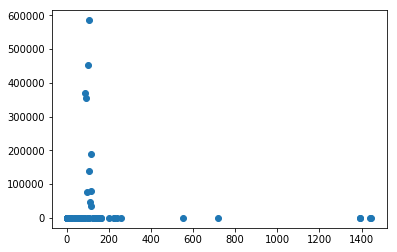

In [81]:
plt.scatter("偏度","均值", data = sak)
plt.show() #所有数据点都堆在一起，看不出任何规律

为解决这个问题，绘制三个纵坐标数值不同的图像——

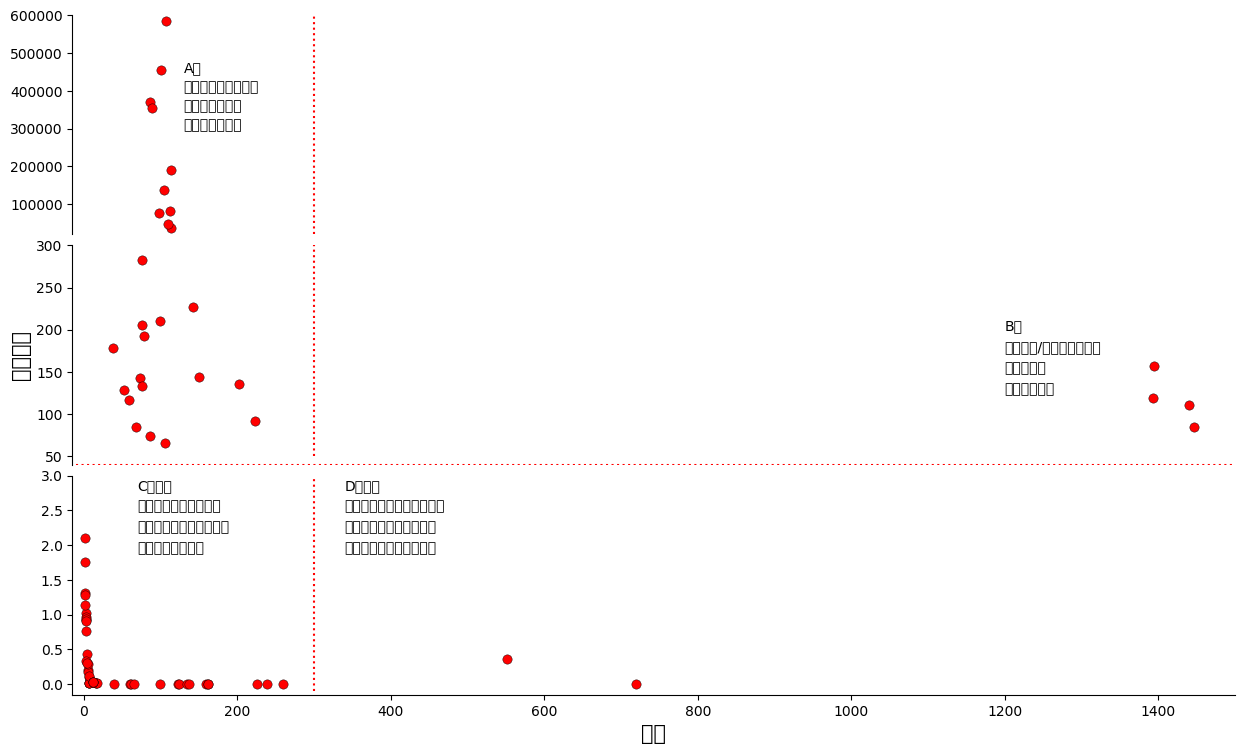

In [82]:
plt.figure(figsize=(15,9),dpi=100)
#绘制三个坐标轴不一样的图像

#上
plt.subplot(311)
plt.scatter("偏度","均值", data = sak
           ,s = 45
           ,c = "red"
           ,edgecolors = "k"
           ,linewidth = 0.3);
plt.xlim(-15, 1500) #控制横纵坐标的范围
plt.ylim(20000, 600000)
plt.vlines(300, 20000, 600000,colors="red",linestyles="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yticks(fontsize=10)
plt.text(130,450000,s="A类")
plt.text(130,400000,s="均值很高，偏度较低")
plt.text(130,350000,s="容易获取的资源")
plt.text(130,300000,s="容易达到的等级")
plt.xticks([])

#中
plt.subplot(312)
plt.scatter("偏度","均值", data = sak
           ,s = 45
           ,c = "red"
           ,edgecolors = "k"
           ,linewidth = 0.3);
plt.xlim(-15, 1500)
plt.ylim(40, 300)
plt.vlines(300, 50, 300,colors="red",linestyles="dotted")
plt.hlines(40,-10, 1500,colors="red",linestyles="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yticks(fontsize=10)
plt.ylabel("资源均值", fontsize=15)
plt.text(1200,200,s="B类")
plt.text(1200,175,s="均值偏高/居中，偏度很高")
plt.text(1200,150,s="有少数玩家")
plt.text(1200,125,s="把控巨量资源")
plt.xticks([])

#下
plt.subplot(313)
plt.scatter("偏度","均值", data = sak
           ,s = 45
           ,c = "red"
           ,edgecolors = "k"
           ,linewidth = 0.3);
plt.xlim(-15, 1500)
plt.ylim(-0.15, 3)
plt.vlines(300, -0.1, 5,colors="red",linestyles="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("偏度", fontsize=15)
plt.yticks(fontsize=10)
plt.text(70,2.8,s="C类资源")
plt.text(70,2.5,s="均值很低，偏度也很低")
plt.text(70,2.2,s="几乎没有玩家拥有该资源")
plt.text(70,1.9,s="可能需要时间积累")
plt.text(340,2.8,s="D类资源")
plt.text(340,2.5,s="均值很低，偏度较高或很高")
plt.text(340,2.2,s="只有少量玩家掌握该资源")
plt.text(340,1.9,s="并且资源本身也比较稀缺")
plt.subplots_adjust(hspace=0.05)
plt.show()

查看一下四类资源分别有哪些，以及数量是否合理：

In [83]:
#A类
A = sak.loc[sak["均值"] > 3,:].loc[sak["偏度"]<300,:]

In [84]:
A

,特征,偏度,峰度,均值
0,木头获取数量,100.635,15449.582,454306.859
1,木头消耗数量,86.310,11367.448,369843.252
2,石头获取数量,113.794,18489.107,189778.774
3,石头消耗数量,105.043,15515.988,137607.363
4,象牙获取数量,112.636,17682.030,80756.230
5,象牙消耗数量,113.405,16974.594,36131.699
6,肉获取数量,106.645,17907.029,585515.505
7,肉消耗数量,89.403,13600.967,354810.206
8,魔法获取数量,97.762,14958.235,75389.535
9,魔法消耗数量,109.334,18322.774,47253.994


In [85]:
A.shape

(27, 4)

In [86]:
#B类
sak.loc[sak["均值"] > 3,:].loc[sak["偏度"]>300,:]

,特征,偏度,峰度,均值
14,萨满招募数量,1393.339,2048745.112,119.543
15,萨满损失数量,1394.118,2050265.411,156.853
20,萨满伤兵产生数量,1439.747,2141351.573,110.431
21,萨满伤兵恢复数量,1446.870,2155525.025,84.763


In [87]:
#C类 - 大量还未开发的资源 & 大量的等级 - 比较容易获得的资源
sak.loc[sak["均值"] < 3,:].loc[sak["偏度"]<300,:].shape[0]

43

In [88]:
#D类 - 极度稀缺的资源
sak.loc[sak["均值"] < 3,:].loc[sak["偏度"]>300,:].shape[0]

2

In [89]:
data.loc[:,A["特征"]].describe().T

,count,mean,std,min,25%,50%,75%,max
字段解释,,,,,,,,
木头获取数量,2288007.000,454306.859,4958667.146,0.000,0.000,42038.000,153118.000,1239962311.000
木头消耗数量,2288007.000,369843.252,3737720.038,0.000,0.000,9830.000,98557.000,799587506.000
石头获取数量,2288007.000,189778.774,4670619.517,0.000,0.000,0.000,0.000,1214869437.000
石头消耗数量,2288007.000,137607.363,3370166.356,0.000,0.000,0.000,0.000,796237770.000
象牙获取数量,2288007.000,80756.230,2220540.322,0.000,0.000,0.000,0.000,574496104.000
象牙消耗数量,2288007.000,36131.699,1782498.688,0.000,0.000,0.000,0.000,448197157.000
肉获取数量,2288007.000,585515.505,5868629.397,0.000,0.000,34587.000,136001.000,1470643810.000
肉消耗数量,2288007.000,354810.206,3400632.455,0.000,0.000,6470.000,66054.000,888953714.000
魔法获取数量,2288007.000,75389.535,966289.236,0.000,0.000,0.000,0.000,263722820.000


从分析的结果来看，各项资源的配比数量其实还算合理。假设一款游戏只想服务氪金玩家，那B类资源会很多、大量A类资源的获取渠道也会转向氪金方向，但《野蛮时代》明显没有这样的设计，在游戏早期只有兵种萨满相关的集中资源和技能是需要氪金的，说明游戏依然在致力于为普通玩家提供较好的体验，所以大部分用户应该不是因为新手关太难、剧情无法推进才退游的。然而，各类资源的可获取量其实有很大的差异，基础资源动辄就上百万甚至上亿，可能会让用户获得感严重不足。而从A类资源的分布来看，只有木头和肉这两种最最最基础的资源是分布较为正常的，其他资源都是严重正偏，**说明“留存率低”是原因，“资源数据的异常”是结果**。最有可能的情况就是产品逻辑不顺、获得感不足、美工不足、系统BUG（比如疯狂闪退等等）、或者强烈的捞金感/不高级感让大部分用户在第一天就流失掉了。

#### 3.平衡性影响：氪金与战斗优势

如果游戏对于新手并非很难上手，那是否是战斗力系统的设置让非氪玩家感觉不太友好呢？过于强大的角色、过于强大的技能和道具都可能影响游戏平衡性，平衡性这个复杂的指标其实可以从很多方面来进行考虑，可惜在现有数据下，我们能够考虑的唯有胜率。我们可以分析氪金用户与不氪金用户的战力差异，来判断氪金对游戏平衡性的影响。

In [90]:
data.columns.tolist()

['玩家唯一ID',
 '玩家注册时间',
 '木头获取数量',
 '木头消耗数量',
 '石头获取数量',
 '石头消耗数量',
 '象牙获取数量',
 '象牙消耗数量',
 '肉获取数量',
 '肉消耗数量',
 '魔法获取数量',
 '魔法消耗数量',
 '勇士招募数量',
 '勇士损失数量',
 '驯兽师招募数量',
 '驯兽师损失数量',
 '萨满招募数量',
 '萨满损失数量',
 '勇士伤兵产生数量',
 '勇士伤兵恢复数量',
 '驯兽师伤兵产生数量',
 '驯兽师伤兵恢复数量',
 '萨满伤兵产生数量',
 '萨满伤兵恢复数量',
 '通用加速获取数量',
 '通用加速使用数量',
 '建筑加速获取数量',
 '建筑加速使用数量',
 '科研加速获取数量',
 '科研加速使用数量',
 '训练加速获取数量',
 '训练加速使用数量',
 '治疗加速获取数量',
 '治疗加速使用数量',
 '建筑：士兵小屋等级',
 '建筑：治疗小井等级',
 '建筑：要塞等级',
 '建筑：据点传送门等级',
 '建筑：兵营等级',
 '建筑：治疗之泉等级',
 '建筑：智慧神庙等级',
 '建筑：联盟大厅等级',
 '建筑：仓库等级',
 '建筑：瞭望塔等级',
 '建筑：魔法幸运树等级',
 '建筑：战争大厅等级',
 '建筑：联盟货车等级',
 '建筑：占卜台等级',
 '建筑：祭坛等级',
 '建筑：冒险传送门等级',
 '科研：侦查等级',
 '科研：训练速度等级',
 '科研：守护者',
 '科研：巨兽驯兽师',
 '科研：吟唱者',
 '科研：勇士攻击',
 '科研：驯兽师攻击',
 '科研：萨满攻击',
 '科研：战斗大师',
 '科研：高阶巨兽骑兵',
 '科研：图腾大师',
 '科研：部队防御',
 '科研：勇士防御',
 '科研：驯兽师防御',
 '科研：萨满防御',
 '科研：勇士生命',
 '科研：驯兽师生命',
 '科研：萨满生命',
 '科研：狂战士',
 '科研：龙骑兵',
 '科研：神谕者',
 '科研：部队攻击',
 '科研：建造速度',
 '科研：资源保护',
 '科研：部队消耗',
 '科研：木材生产',
 '科研：石头生产',
 '科研：象牙生产',
 '科研：肉类生产',
 '科研：木材采集',
 '科研：石头采集',


In [91]:
#7日氪金玩家的人均PVP次数 - 氪金玩家是否热衷于战斗
data[data["付费金额"] !=0]["PVP次数"].mean()

25.193802939260117

In [92]:
#7日氪金玩家PVP胜率分布
(data[data["付费金额"] !=0]["PVP胜利次数"]/data[data["付费金额"] !=0]["PVP次数"]).describe()

count   35755.000
mean        0.533
std         0.360
min         0.000
25%         0.200
50%         0.600
75%         0.865
max         1.000
dtype: float64

可以看到，人均PVP胜率是53.27%，对手游付费玩家来说是个可以接受的数字，但并不是特别大的优势。其中count数是少于总付费玩家的人数的，说明有部分玩家的PVP次数为0，为避免除0错误因此剔除了这些玩家。不参与PVP的玩家占比为：

In [93]:
1 - 35755/data[data["付费金额"] !=0].shape[0] #13%的付费玩家从不玩PVP

0.1371654721397717

In [94]:
#不氪金玩家的人均PVP次数
data[data["付费金额"] == 0]["PVP次数"].mean()

1.723228497868749

In [95]:
#不氪金玩家PVP胜率分布
(data[data["付费金额"] == 0]["PVP胜利次数"]/data[data["付费金额"] ==0]["PVP次数"]).describe()

count   539947.000
mean         0.254
std          0.355
min          0.000
25%          0.000
50%          0.000
75%          0.500
max          1.000
dtype: float64

对非付费玩家而言，人均PVP胜率只有25%，并且75%的人的场均胜率不到50%，这个条件对非付费玩家来说的确比较苛刻。同样，不氪金玩家中也有部分玩家的PVP次数为0，即一次也没有参与。来看不氪金玩家中参与PVP的人数占比：

In [96]:
1 - 539947/data[data["付费金额"] ==0].shape[0]

0.7596569522934539

这个比例奇高，当然，不氪金用户中有许多人可能是已经流失的用户，因此当然不会参与PVP对战。

In [97]:
#氪金玩家会更好战？不氪玩家更佛系？
(data[data["付费金额"] !=0]["主动发起PVP次数"]/data[data["付费金额"] !=0]["PVP次数"]).describe()

count   35755.000
mean        0.452
std         0.357
min         0.000
25%         0.000
50%         0.500
75%         0.783
max         1.000
dtype: float64

对付费玩家而言，平均有45%的PVP对战是由他们主动发起的。

In [98]:
(data[data["付费金额"] ==0]["主动发起PVP次数"]/data[data["付费金额"] ==0]["PVP次数"]).describe()

count   539947.000
mean         0.262
std          0.365
min          0.000
25%          0.000
50%          0.000
75%          0.500
max          1.000
dtype: float64

不付费玩家则有26%的时候主动发起对战，不过大多数时候75%的人都不会发起对战。

如果PVP状况下是付费玩家占绝对优势，那PVE也是相同的情况吗？

In [99]:
#氪金玩家PVE胜率分布
(data[data["付费金额"] !=0]["PVE胜利次数"]/data[data["付费金额"] !=0]["PVE次数"]).describe()

count   37389.000
mean        0.885
std         0.141
min         0.000
25%         0.840
50%         0.926
75%         0.988
max         1.000
dtype: float64

In [100]:
#不氪金玩家PVE胜率分布
(data[data["付费金额"] ==0]["PVE胜利次数"]/data[data["付费金额"] ==0]["PVE次数"]).describe()

count   703148.000
mean         0.921
std          0.179
min          0.000
25%          0.965
50%          1.000
75%          1.000
max          1.000
dtype: float64

不难发现，不氪金玩家的PVE平均胜率有92%，是高于氪金玩家的品滚胜率88%的，看来环境怪兽都比较弱小，大部分玩家都能够轻松战胜。当PVP上氪金玩家有绝对优势时，不氪金玩家许多会选择在PVE环境中进行战斗，因此我们推断不氪金玩家主动发起PVE战斗的情况会更多：

In [101]:
#在PVE系统中，付费玩家主动发起战斗的概率
(data[data["付费金额"] !=0]["主动发起PVE次数"]/data[data["付费金额"] !=0]["PVE次数"]).describe()

count   37389.000
mean        0.991
std         0.067
min         0.000
25%         1.000
50%         1.000
75%         1.000
max         1.000
dtype: float64

In [102]:
#在PVE系统中，不付费玩家主动发起战斗的概率
(data[data["付费金额"] == 0]["主动发起PVE次数"]/data[data["付费金额"] ==0]["PVE次数"]).describe()

count   703148.000
mean         0.996
std          0.056
min          0.000
25%          1.000
50%          1.000
75%          1.000
max          1.000
dtype: float64

氪金与不氪金玩家主动放弃PVE的可能性都非常高，几乎所有人都是主动发起PVE战斗，这可能说明PVE战斗是发展城市必须的环节（比如收集资源肉类需要猎杀野猪等生物、获取魔法道具需要猎杀龙、哥布林等生物）。从分析的结果来看，氪金并不会对PVE战斗有影响，主要是影响PVP。《野蛮时代》中玩家或许可以夺取其他玩家的领地和城池，因此PVP对战的平衡性对玩家流失有重要的影响。前期留存下来，但后期逐渐流失的非氪金用户有一定的可能是因为PVP胜率太低而离开。

#### 4. 正偏带来长尾：谁是异常玩家？

在特征高度正偏的情况下，数据中必然含有大量的异常值，这些异常值可能代表着某些特殊的人群，但带入异常值进行建模会严重影响模型的稳定性，导致模型容易过拟合。因此在建模之前，我们需要对异常值进行简单的探索，以确定异常值的处理方法。

 - 查看业务上的异常值

> 从游戏业务角度而言，所有的资源/人物等级/胜利次数/金额等不应该出现负数，因此首先排查负数<br>
> 如果存在用户信息，则需要排查年龄不为负，年龄不过高或过低等状况<br>
> 查看是否有上线时间较短，但是资源量异常丰富的账号，可能是GM，也可能有人作弊

In [103]:
data.columns[2:-1] #不对ID，注册时间和标签（45日付费金额）计算异常值

Index(['木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量', '象牙消耗数量', '肉获取数量',
       '肉消耗数量', '魔法获取数量', '魔法消耗数量',
       ...
       '科研：资源帮助容量', 'PVP次数', '主动发起PVP次数', 'PVP胜利次数', 'PVE次数', '主动发起PVE次数',
       'PVE胜利次数', '在线时长', '付费金额', '付费次数'],
      dtype='object', name='字段解释', length=106)

In [104]:
AbnormalCheck = data.iloc[:,2:-1]

In [105]:
AbnormalCheck.info() #确认已没有任何object对象

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288007 entries, 0 to 2288006
Columns: 106 entries, 木头获取数量 to 付费次数
dtypes: float64(12), int64(94)
memory usage: 1.8 GB


In [106]:
(AbnormalCheck < 0).sum().sum() #无小于0的值

0

In [107]:
#通常我们还会检查在线时间很短但却拥有很多资源的账号，可能是作弊账号
#但以目前游戏1分钟积累4w资源、3分钟积累十几万资源的状况来看，很难去判断资源出现异常的“阈值”

In [108]:
AbnormalCheck.loc[AbnormalCheck["在线时长"] < 30,:]

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,科研：资源帮助容量,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数
0,20125.000,3700.000,0.000,0.000,0.000,0.000,16375.000,2000.000,0.000,0.000,...,0,0,0,0,0,0,0,0.333,0.000,0
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0.333,0.000,0
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,1.167,0.000,0
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,3.167,0.000,0
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,2.333,0.000,0
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0.167,0.000,0
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,4.000,0.000,0
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0.667,0.000,0
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,1.833,0.000,0
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0,0.500,0.000,0


**我们先使用箱线图的法则，看看会筛选出多少异常值。**

[QL - 1.5IQR   ,  QU+1.5IQR]

(feature < QL - 1.5IQR).astype(int) #---->布尔值 
+
(feature > QU + 1.5IQR).astype(int) #---->布尔值

In [110]:
#打印异常比例，保存异常样本的索引
NumOfSamples = data.shape[0]
abnormal = pd.DataFrame()
DataNoAbnormal = data.copy()
BoxAbnormalIdx = [] #列表：用于保存我们的异常值的索引
for idx,column in enumerate(data.columns[2:-1]):
    feature = data.loc[:,column]
    QL = np.quantile(feature,0.25)
    QU = np.quantile(feature,0.75)
    IQR = QU - QL
    #过小或过大的都属于异常值
    error = feature[((feature < (QL - 1.5*IQR)).astype(int) + (feature > (QU + 1.5*IQR)).astype(int)) != 0]
    BoxAbnormalIdx.extend(error.index)
    abnormal.loc[idx,"特征"] = column
    abnormal.loc[idx,"异常值数量"] = error.shape[0]
    abnormal.loc[idx,"异常值比例"] = "{:.3f}%".format(error.shape[0]*100/NumOfSamples)

In [111]:
len(BoxAbnormalIdx) #这里面是由重复值的

21155828

In [112]:
BoxAbnormalIdx = set(BoxAbnormalIdx) #利用集合对筛选出的异常值的索引进行去重

In [113]:
len(BoxAbnormalIdx) #超过100w数据都被归为异常，数量太多无法直接删除，何况在7日内付费的用户只有4w多，很可能被这100多万数据囊括

2288007

In [114]:
abnormal.sort_values("异常值比例",ascending=False) #左偏比较严重的特征异常值更多

,特征,异常值数量,异常值比例
39,建筑：联盟大厅等级,215420.000,9.415%
15,萨满损失数量,207173.000,9.055%
26,科研加速获取数量,195901.000,8.562%
20,萨满伤兵产生数量,183496.000,8.020%
84,科研：据点耐久,162146.000,7.087%
43,建筑：战争大厅等级,160448.000,7.013%
70,科研：建造速度,147491.000,6.446%
14,萨满招募数量,146429.000,6.400%
47,建筑：冒险传送门等级,145062.000,6.340%
17,勇士伤兵恢复数量,131702.000,5.756%


**再使用3sigma法则试试看**

In [115]:
#打印异常比例，保存异常样本的索引
NumOfSamples = data.shape[0]
abnormal = pd.DataFrame()
DataNoAbnormal = data.copy()
SigmaAbnormalIdx = []
for idx,column in enumerate(data.columns[2:-1]):
    feature = data.loc[:,column]
    mean_ = feature.mean()
    std_ = feature.std()
    error = feature[feature - mean_ > 3*std_]
    SigmaAbnormalIdx.extend(error.index)
    abnormal.loc[idx,"特征"] = column
    abnormal.loc[idx,"异常值数量"] = error.shape[0]
    abnormal.loc[idx,"异常值比例"] = "{:.3f}%".format(error.shape[0]*100/NumOfSamples)

In [116]:
len(SigmaAbnormalIdx)

7065592

In [117]:
SigmaAbnormalIdx = set(SigmaAbnormalIdx) #对异常样本索引去重

In [118]:
len(SigmaAbnormalIdx) #23w样本是异常，这是一个可以接受的数字，可以直接删除，但放入模型后的效果不知道怎么样

2288007

**在箱线图规则下，我们看看这些异常用户的游戏时间/氪金情况**

In [119]:
data.loc[BoxAbnormalIdx,"在线时长"].describe() #在在线时长上，表现是位于氪金用户与不可尽用户之间

count   2288007.000
mean         10.207
std          38.959
min           0.000
25%           0.500
50%           1.833
75%           4.833
max        2049.667
Name: 在线时长, dtype: float64

In [120]:
(data.loc[BoxAbnormalIdx,"付费金额"] != 0).sum() #在异常用户中，付费用户的数量

41439

In [121]:
(data.loc[:,"付费金额"] != 0).sum() #所有7日付费用户数

41439

In [122]:
(data.loc[BoxAbnormalIdx,"45日付费金额"] != 0).sum() #在异常用户中，付费用户的数量

45988

In [123]:
(data.loc[:,"45日付费金额"] != 0).sum() #所有7日付费用户数

45988

付费用户被100%包含在了异常用户里，这说明：
> - 付费用户的数据在现有数据的大背景下（大部分用户短时间快速流失掉）下，在统计上是完全异常的，因此建模时想要辨认出付费用户，模型需要很深入的学习，有很高的过拟合风险<br>
> - 异常用户有100w，其中只有4w多付费，即许多与氪金用户行为高度相似的用户都没有氪金，对算法来说这部分用户是很难判断的

## 模型构筑：从0实现用户氪金行为预测

### 1. 导库，整合数据

In [124]:
#更改列名为中文
data = pd.read_csv(r"tap_fun_train.csv")
column_name = pd.read_excel(r"tap4fun 数据字段解释.xlsx")
data.columns = column_name["字段解释"]

In [125]:
data.head()

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
0,1,2018-02-02 19:47:15,20125.000,3700.000,0.000,0.000,0.000,0.000,16375.000,2000.000,...,0,0,0,0,0,0,0.333,0.000,0,0.000
1,1593,2018-01-26 00:01:05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0.333,0.000,0,0.000
2,1594,2018-01-26 00:01:58,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,1.167,0.000,0,0.000
3,1595,2018-01-26 00:02:13,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,3.167,0.000,0,0.000
4,1596,2018-01-26 00:02:46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,2.333,0.000,0,0.000


### 2. 数据预处理：注册时间与氪金状况有关吗？

从游戏世界的常识以及之前的分析结果来看，资源量的累计、在线时长等特征与用户体验的深度有较大的关联，也就与是否氪金、氪多少金额有较大的关联。但在我们的特征矩阵中，还有一类尚未分析的特征，玩家注册时间，这是全数据集中唯一一个object类型的对象。

In [126]:
data.loc[:,"玩家注册时间"]

0          2018-02-02 19:47:15
1          2018-01-26 00:01:05
2          2018-01-26 00:01:58
3          2018-01-26 00:02:13
4          2018-01-26 00:02:46
5          2018-01-26 00:03:06
6          2018-01-26 00:03:45
7          2018-01-26 00:04:11
8          2018-01-26 00:06:01
9          2018-01-26 00:07:42
10         2018-01-26 00:07:47
11         2018-01-26 00:10:27
12         2018-01-26 00:10:34
13         2018-01-26 00:11:19
14         2018-01-26 00:13:32
15         2018-01-26 00:13:41
16         2018-01-26 00:15:14
17         2018-01-26 00:17:14
18         2018-01-26 00:17:36
19         2018-01-26 00:17:56
20         2018-01-26 00:18:14
21         2018-01-26 00:19:00
22         2018-01-26 00:20:22
23         2018-01-26 00:20:47
24         2018-01-26 00:22:52
25         2018-01-26 00:23:42
26         2018-01-26 00:23:52
27         2018-01-26 00:23:58
28         2018-01-26 00:24:03
29         2018-01-26 00:24:24
                  ...         
2287977    2018-02-03 14:33:31
2287978 

从常识来看，一般注册时间与用户的氪金行为应该关系不大，在这里我们将时间分成日期和时刻来考虑，分别绘制横坐标为注册日期/注册时刻、纵坐标为该日期/该时刻注册用户氪金均值的关系图，以此来观察注册日期、时刻与氪金是否有关。

In [129]:
#首先将玩家注册日期提取出来作为新的一列
RegisterDate = data.loc[:,"玩家注册时间"].apply(lambda x: x[:10])

In [130]:
RegisterDate

0          2018-02-02
1          2018-01-26
2          2018-01-26
3          2018-01-26
4          2018-01-26
5          2018-01-26
6          2018-01-26
7          2018-01-26
8          2018-01-26
9          2018-01-26
10         2018-01-26
11         2018-01-26
12         2018-01-26
13         2018-01-26
14         2018-01-26
15         2018-01-26
16         2018-01-26
17         2018-01-26
18         2018-01-26
19         2018-01-26
20         2018-01-26
21         2018-01-26
22         2018-01-26
23         2018-01-26
24         2018-01-26
25         2018-01-26
26         2018-01-26
27         2018-01-26
28         2018-01-26
29         2018-01-26
              ...    
2287977    2018-02-03
2287978    2018-02-03
2287979    2018-02-03
2287980    2018-02-03
2287981    2018-02-03
2287982    2018-02-03
2287983    2018-02-03
2287984    2018-02-03
2287985    2018-02-03
2287986    2018-02-03
2287987    2018-02-03
2287988    2018-02-03
2287989    2018-02-03
2287990    2018-02-03
2287991   

In [131]:
#按照玩家注册日期对付费金额进行聚合平均计算
RegisterDateMean = data["付费金额"].groupby(RegisterDate).mean()

In [132]:
RegisterDateMean

玩家注册时间
2018-01-26   0.829
2018-01-27   0.412
2018-01-28   0.425
2018-01-29   0.565
2018-01-30   0.777
2018-01-31   0.354
2018-02-01   0.305
2018-02-02   0.847
2018-02-03   0.741
2018-02-04   0.440
2018-02-05   0.684
2018-02-06   0.413
2018-02-07   0.455
2018-02-08   0.478
2018-02-09   0.654
2018-02-10   0.682
2018-02-11   0.405
2018-02-12   0.820
2018-02-13   0.460
2018-02-14   0.485
2018-02-15   0.253
2018-02-16   0.811
2018-02-17   0.400
2018-02-18   0.397
2018-02-19   0.371
2018-02-20   0.271
2018-02-21   0.436
2018-02-22   0.478
2018-02-23   1.042
2018-02-24   0.702
2018-02-25   0.515
2018-02-26   0.957
2018-02-27   0.413
2018-02-28   0.527
2018-03-01   0.503
2018-03-02   0.702
2018-03-03   0.390
2018-03-04   0.382
2018-03-05   0.695
2018-03-06   0.808
Name: 付费金额, dtype: float64

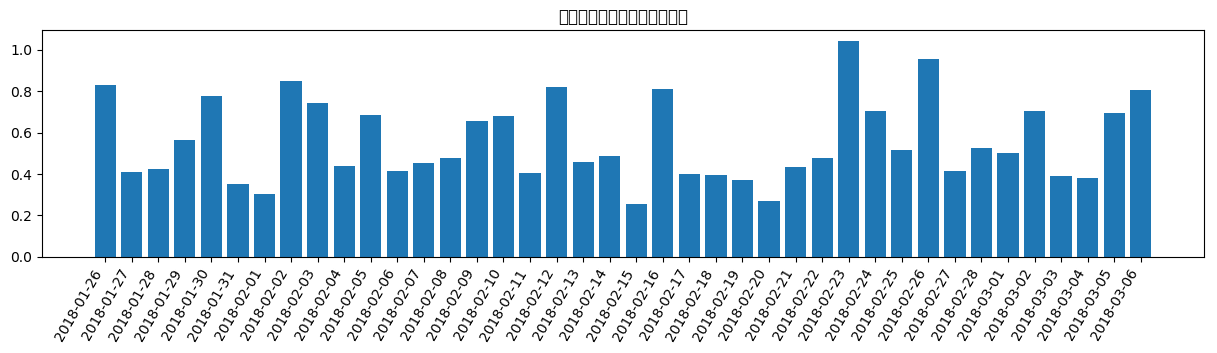

In [133]:
#绘制图像
plt.figure(figsize=(15,3),dpi=100)
plt.title("不同注册日期的用户氪金均值")
plt.bar(RegisterDateMean.index, RegisterDateMean.values)
plt.xticks(RegisterDateMean.index,rotation=60,ha="right");

从图上来看，几乎无法看出日期与氪金数额有所联系。看起来整体是比较随机而且杂乱的，但是每隔几天就会有一个高峰。查看将日期转化为一星期中的七天，观察一下星期和氪金数额是否有明显的关系。

In [134]:
#必须要将字符串转化为python可以读取的时间格式，这样python才能够基于日期帮助我辨别，这个日期是星期几
datetime.datetime.strptime(data.loc[0,"玩家注册时间"][:10],"%Y-%m-%d").weekday()

4

In [135]:
#weekday - [0,1,2,3,4,5,6]

In [136]:
RegisterWeekday = data.loc[:,"玩家注册时间"].apply(lambda x: datetime.datetime.strptime(x[:10],"%Y-%m-%d").weekday()+1) #1~7分别代表周一到周日

In [137]:
RegisterWeekday

0          5
1          5
2          5
3          5
4          5
5          5
6          5
7          5
8          5
9          5
10         5
11         5
12         5
13         5
14         5
15         5
16         5
17         5
18         5
19         5
20         5
21         5
22         5
23         5
24         5
25         5
26         5
27         5
28         5
29         5
          ..
2287977    6
2287978    6
2287979    6
2287980    6
2287981    6
2287982    6
2287983    6
2287984    6
2287985    6
2287986    6
2287987    6
2287988    6
2287989    6
2287990    6
2287991    6
2287992    6
2287993    6
2287994    6
2287995    6
2287996    6
2287997    6
2287998    6
2287999    6
2288000    6
2288001    6
2288002    6
2288003    6
2288004    6
2288005    6
2288006    6
Name: 玩家注册时间, Length: 2288007, dtype: int64

In [138]:
RegisterWeekDayMean = data["付费金额"].groupby(RegisterWeekday).mean()

In [139]:
RegisterWeekDayMean

玩家注册时间
1   0.618
2   0.485
3   0.448
4   0.378
5   0.815
6   0.549
7   0.426
Name: 付费金额, dtype: float64

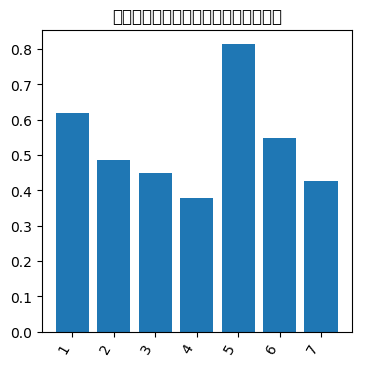

In [141]:
#绘制图像
plt.figure(figsize=(4,4),dpi=100)
plt.title("不同注册日期（星期）的用户氪金均值")
plt.bar(RegisterWeekDayMean.index, RegisterWeekDayMean.values)
plt.xticks(RegisterWeekDayMean.index,rotation=60,ha="right");

很明显，周五、周一注册的人有较高的氪金金额，并且在高峰之后会逐渐下降。这个趋势看起来是氪金金额与星期相关，但实际上更可能是跟游戏买量、投放的节奏和渠道有关。或许每周五、每周一都可以排到质量较高的用户所在的渠道，或者周五会吸引到大量准备过周末的玩家的注意、周一则会吸引到大量还不想投入工作的玩家的注意。周五与周一的高峰暗示这两天进入的流量可能是有规律工作、有经济收入的人。但无论真相是什么，从特征的角度来看，我们可以计算一下星期与45日付费金额的相关系数：

In [142]:
pd.concat([data["45日付费金额"],RegisterWeekday],axis=1).corr()

,45日付费金额,玩家注册时间
45日付费金额,1.000,0.000
玩家注册时间,0.000,1.000


相关系数非常非常小，两者几乎不相关，不将星期放入特征矩阵了。

In [143]:
#将时刻也单独列一列，提取小时数作为特征
RegisterTime = data.loc[:,"玩家注册时间"].apply(lambda x: int(x[11:13]))

In [144]:
RegisterTime

0          19
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
           ..
2287977    14
2287978    14
2287979    14
2287980    14
2287981    14
2287982    14
2287983    14
2287984    14
2287985    14
2287986    14
2287987    14
2287988    14
2287989    14
2287990    14
2287991    14
2287992    14
2287993    14
2287994    14
2287995    14
2287996    14
2287997    14
2287998    14
2287999    14
2288000    14
2288001    14
2288002    14
2288003    14
2288004    14
2288005    14
2288006    14
Name: 玩家注册时间, Length: 2288007, dtype: int64

In [145]:
#按玩家注册时刻进行聚合，求均值
RegisterTimeMean = data["付费金额"].groupby(RegisterTime).mean()

In [146]:
RegisterTimeMean

玩家注册时间
0    0.543
1    0.432
2    0.350
3    0.400
4    0.390
5    0.427
6    0.427
7    0.363
8    0.371
9    0.335
10   1.268
11   1.028
12   0.726
13   0.520
14   0.570
15   0.640
16   0.725
17   0.450
18   0.465
19   0.383
20   0.388
21   0.432
22   0.599
23   0.571
Name: 付费金额, dtype: float64

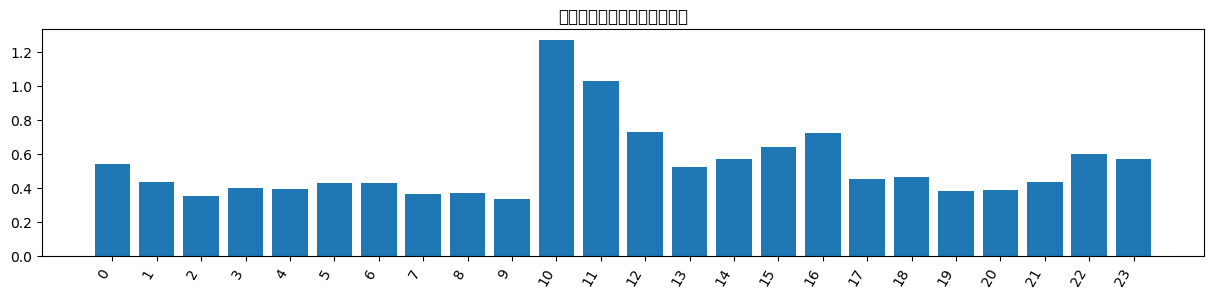

In [147]:
#绘制图像
plt.figure(figsize=(15,3),dpi=100)
plt.title("不同注册时刻的用户氪金均值")
plt.bar(RegisterTimeMean.index, RegisterTimeMean.values)
plt.xticks(RegisterTimeMean.index,rotation=60,ha="right");

早上10点-12点之间注册的用户、以及下午4点-5点之间表现出比其他时段注册的用户更高的氪金能力，这可能是与推广渠道有关，也可能真的是注册时刻与氪金金额有关。巧合的是，上午10点与下午4点正是上班时间中摸鱼喝茶的时间，如果能够确定这个时间在推广的是哪些渠道，就能够确定相关用户的画像，来判断是否真是时间与氪金数额有关了。同时，也来看看相关系数：

In [148]:
pd.concat([data["45日付费金额"],RegisterTime],axis=1).corr()

,45日付费金额,玩家注册时间
45日付费金额,1.000,0.001
玩家注册时间,0.001,1.000


看起来注册时刻与付费金额有一点点关系（非常微弱），我们可以保留注册时刻为建模用。

增加玩家注册时刻作为特征，注意要添加到标签的前面，维持标签是最后一列

In [149]:
data.shape[1]

109

In [150]:
data.insert(data.shape[1]-1,"玩家注册时刻",RegisterTime)

现在可以删除最初的“注册时间”这个特征了，同时，也可以将玩家唯一ID删除，因为ID应当不是有助于建模的特征。

In [151]:
data.drop(columns=["玩家注册时间","玩家唯一ID"],inplace=True) #删除不需要的特征

In [152]:
data.columns

Index(['木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量', '象牙消耗数量', '肉获取数量',
       '肉消耗数量', '魔法获取数量', '魔法消耗数量',
       ...
       '主动发起PVP次数', 'PVP胜利次数', 'PVE次数', '主动发起PVE次数', 'PVE胜利次数', '在线时长', '付费金额',
       '付费次数', '玩家注册时刻', '45日付费金额'],
      dtype='object', name='字段解释', length=108)

### 3. 模型选择与benchmark

In [153]:
data.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,玩家注册时刻,45日付费金额
0,20125.000,3700.000,0.000,0.000,0.000,0.000,16375.000,2000.000,0.000,0.000,...,0,0,0,0,0,0.333,0.000,0,19,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0.333,0.000,0,0,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,1.167,0.000,0,0,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,3.167,0.000,0,0,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,2.333,0.000,0,0,0.000


In [154]:
#将标签提取出来，分割标签与特征
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [155]:
y.shape

(2288007,)

In [156]:
X.shape

(2288007, 107)

In [157]:
y.head()

0   0.000
1   0.000
2   0.000
3   0.000
4   0.000
Name: 45日付费金额, dtype: float64

**建立benchmark**

In [158]:
from sklearn.linear_model import LinearRegression as LR #线性回归
from sklearn.model_selection import train_test_split as TTS #分割训练集与测试集的类
from sklearn.metrics import mean_squared_error as MSE #模型评估指标

In [159]:
#数据分割
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.3,random_state=1412)

In [160]:
Xtrain.shape

(1601604, 107)

In [161]:
Xtest.shape

(686403, 107)

In [162]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,玩家注册时刻
243592,10000.000,600.000,0.000,0.000,0.000,0.000,10000.000,400.000,0.000,0.000,...,0,0,0,0,0,0,0.167,0.000,0,19
361662,39038.000,8750.000,0.000,0.000,3000.000,0.000,42434.000,6060.000,0.000,0.000,...,1,0,0,1,1,1,0.833,0.000,0,12
1319519,10000.000,1600.000,0.000,0.000,0.000,0.000,10000.000,900.000,0.000,0.000,...,0,0,0,0,0,0,0.167,0.000,0,15
276423,26625.000,6900.000,0.000,0.000,0.000,0.000,31625.000,3900.000,0.000,0.000,...,1,1,0,0,0,0,4.500,0.000,0,9
1060863,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0.667,0.000,0,4


In [163]:
#分割完毕后需要恢复索引
for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0])

In [164]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,玩家注册时刻
0,10000.000,600.000,0.000,0.000,0.000,0.000,10000.000,400.000,0.000,0.000,...,0,0,0,0,0,0,0.167,0.000,0,19
1,39038.000,8750.000,0.000,0.000,3000.000,0.000,42434.000,6060.000,0.000,0.000,...,1,0,0,1,1,1,0.833,0.000,0,12
2,10000.000,1600.000,0.000,0.000,0.000,0.000,10000.000,900.000,0.000,0.000,...,0,0,0,0,0,0,0.167,0.000,0,15
3,26625.000,6900.000,0.000,0.000,0.000,0.000,31625.000,3900.000,0.000,0.000,...,1,1,0,0,0,0,4.500,0.000,0,9
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,0,0,0.667,0.000,0,4


In [165]:
reg = LR() #实例化

In [166]:
reg_benchmark = reg.fit(Xtrain,Ytrain) #训练

In [167]:
reg_benchmark.score(Xtrain,Ytrain) #训练集上的分数 - R2

0.5604160157526337

In [168]:
reg_benchmark.score(Xtest,Ytest) #测试集上的分数

0.5581998030190543

In [169]:
#模型处于欠拟合的状态 - 在训练集和在测试集上的分数都不是很高，并且两者分数比较相似
#简单的线性模型在学习能力上略显不足

In [170]:
y_pred = reg_benchmark.predict(Xtest) #测试集上的预测标签

In [171]:
# 根均方误差(RMSE)
np.sqrt(MSE(Ytest,y_pred)) #benchmark就是62的RMSE，以及55.8%的r2

62.00116183660692

In [172]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [173]:
#给出非常少的树的数量，以及限制每次分枝所使用的最大特征量

In [174]:
reg_tree = RFR(n_estimators=10,max_features=5) #100+，max_features=5

In [175]:
##=====【TIME WARNING：2mins】======##
reg_tree.fit(Xtrain,Ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [176]:
reg_tree.score(Xtrain,Ytrain) #训练集上的R2是87%

0.8843586084453698

In [177]:
reg_tree.score(Xtest,Ytest) #测试集上的R2是41%

0.45988077452339404

In [178]:
#随机森林处于过拟合的状态 - 只要有机会，可以对随机森林进行抗过拟合的调参，来试着使用树模型

In [179]:
y_pred = reg_tree.predict(Xtest)

In [180]:
np.sqrt(MSE(Ytest,y_pred))

68.5538252853136

这不是一个很好的征兆。通常来说，如果一个数据在线性模型上表现较好，在树模型上表现较差，则说明该数据的分布规律接近线性规律，更适用于线性回归、贝叶斯这些模型。反之，则说明该数据的分布更接近非线性规律，更适合树模型这样的非线性模型。但如果树模型和线性模型表现出差不多的结果、并且两种结果都不高，则说明数据本身的学习难度较大。可以尝试着对随机森林稍微进行调整，会发现无论对模型做什么，模型的RMSE都非常高。

In [181]:
##=====【TIME WARNING：10mins】======##
reg_tree2 = RFR(n_estimators=20,max_features=5).fit(Xtrain,Ytrain) #增大树的数量

In [182]:
np.sqrt(MSE(Ytest,reg_tree2.predict(Xtest)))

66.69943001058651

In [183]:
reg_tree3 = RFR(n_estimators=20,max_depth=2,max_features=5).fit(Xtrain,Ytrain) #控制最大深度

In [184]:
np.sqrt(MSE(Ytest,reg_tree3.predict(Xtest)))

70.17771944153394

### 4. 特征工程(1)：根据业务模式新增特征

In [185]:
X.columns.tolist() #能够从我自己的特征矩阵里分别出，哪些是技能，哪些是资源

['木头获取数量',
 '木头消耗数量',
 '石头获取数量',
 '石头消耗数量',
 '象牙获取数量',
 '象牙消耗数量',
 '肉获取数量',
 '肉消耗数量',
 '魔法获取数量',
 '魔法消耗数量',
 '勇士招募数量',
 '勇士损失数量',
 '驯兽师招募数量',
 '驯兽师损失数量',
 '萨满招募数量',
 '萨满损失数量',
 '勇士伤兵产生数量',
 '勇士伤兵恢复数量',
 '驯兽师伤兵产生数量',
 '驯兽师伤兵恢复数量',
 '萨满伤兵产生数量',
 '萨满伤兵恢复数量',
 '通用加速获取数量',
 '通用加速使用数量',
 '建筑加速获取数量',
 '建筑加速使用数量',
 '科研加速获取数量',
 '科研加速使用数量',
 '训练加速获取数量',
 '训练加速使用数量',
 '治疗加速获取数量',
 '治疗加速使用数量',
 '建筑：士兵小屋等级',
 '建筑：治疗小井等级',
 '建筑：要塞等级',
 '建筑：据点传送门等级',
 '建筑：兵营等级',
 '建筑：治疗之泉等级',
 '建筑：智慧神庙等级',
 '建筑：联盟大厅等级',
 '建筑：仓库等级',
 '建筑：瞭望塔等级',
 '建筑：魔法幸运树等级',
 '建筑：战争大厅等级',
 '建筑：联盟货车等级',
 '建筑：占卜台等级',
 '建筑：祭坛等级',
 '建筑：冒险传送门等级',
 '科研：侦查等级',
 '科研：训练速度等级',
 '科研：守护者',
 '科研：巨兽驯兽师',
 '科研：吟唱者',
 '科研：勇士攻击',
 '科研：驯兽师攻击',
 '科研：萨满攻击',
 '科研：战斗大师',
 '科研：高阶巨兽骑兵',
 '科研：图腾大师',
 '科研：部队防御',
 '科研：勇士防御',
 '科研：驯兽师防御',
 '科研：萨满防御',
 '科研：勇士生命',
 '科研：驯兽师生命',
 '科研：萨满生命',
 '科研：狂战士',
 '科研：龙骑兵',
 '科研：神谕者',
 '科研：部队攻击',
 '科研：建造速度',
 '科研：资源保护',
 '科研：部队消耗',
 '科研：木材生产',
 '科研：石头生产',
 '科研：象牙生产',
 '科研：肉类生产',
 '科研：木材采集',
 '科研：石头采集',
 '科研：象牙采集',
 '科研：肉类生产'

In [186]:
GrowthFeature = [] #发育 - 关于资源的部分
for i in X.columns:
    if "招募" in i:
        GrowthFeature.append(i)
    elif "获取" in i:
        GrowthFeature.append(i)

In [187]:
LevelUpFeature = [] #等级 - 关于技能的部分
for i in X.columns:
    if "建筑" in i:
        LevelUpFeature.append(i)
    elif "科研" in i:
        LevelUpFeature.append(i)

In [188]:
GrowthFeature

['木头获取数量',
 '石头获取数量',
 '象牙获取数量',
 '肉获取数量',
 '魔法获取数量',
 '勇士招募数量',
 '驯兽师招募数量',
 '萨满招募数量',
 '通用加速获取数量',
 '建筑加速获取数量',
 '科研加速获取数量',
 '训练加速获取数量',
 '治疗加速获取数量']

In [189]:
LevelUpFeature

['建筑加速获取数量',
 '建筑加速使用数量',
 '科研加速获取数量',
 '科研加速使用数量',
 '建筑：士兵小屋等级',
 '建筑：治疗小井等级',
 '建筑：要塞等级',
 '建筑：据点传送门等级',
 '建筑：兵营等级',
 '建筑：治疗之泉等级',
 '建筑：智慧神庙等级',
 '建筑：联盟大厅等级',
 '建筑：仓库等级',
 '建筑：瞭望塔等级',
 '建筑：魔法幸运树等级',
 '建筑：战争大厅等级',
 '建筑：联盟货车等级',
 '建筑：占卜台等级',
 '建筑：祭坛等级',
 '建筑：冒险传送门等级',
 '科研：侦查等级',
 '科研：训练速度等级',
 '科研：守护者',
 '科研：巨兽驯兽师',
 '科研：吟唱者',
 '科研：勇士攻击',
 '科研：驯兽师攻击',
 '科研：萨满攻击',
 '科研：战斗大师',
 '科研：高阶巨兽骑兵',
 '科研：图腾大师',
 '科研：部队防御',
 '科研：勇士防御',
 '科研：驯兽师防御',
 '科研：萨满防御',
 '科研：勇士生命',
 '科研：驯兽师生命',
 '科研：萨满生命',
 '科研：狂战士',
 '科研：龙骑兵',
 '科研：神谕者',
 '科研：部队攻击',
 '科研：建造速度',
 '科研：资源保护',
 '科研：部队消耗',
 '科研：木材生产',
 '科研：石头生产',
 '科研：象牙生产',
 '科研：肉类生产',
 '科研：木材采集',
 '科研：石头采集',
 '科研：象牙采集',
 '科研：肉类生产',
 '科研：部队负重',
 '科研：魔法采集',
 '科研：魔法生产',
 '科研：据点耐久',
 '科研：据点二',
 '科研：医院容量',
 '科研：领土采集奖励',
 '科研：治疗速度',
 '科研：据点三',
 '科研：联盟行军速度',
 '科研：战斗行军速度',
 '科研：采集行军速度',
 '科研：据点四',
 '科研：增援部队容量',
 '科研：行军大小',
 '科研：资源帮助容量']

In [190]:
X["PVP胜率"] = X["PVP胜利次数"]/X["PVP次数"]
X["主动发起PVP的概率"] = X["主动发起PVP次数"]/X["PVP次数"]
X["玩家发育效率"] = X.loc[:,GrowthFeature].mean(axis=1)/X["在线时长"]
X["氪金发育效率"] = X.loc[:,GrowthFeature].mean(axis=1)/X["付费金额"]
X["玩家升级效率"] = X.loc[:,LevelUpFeature].mean(axis=1)/X["在线时长"]
X["氪金升级效率"] = X.loc[:,LevelUpFeature].mean(axis=1)/X["付费金额"]

In [191]:
X["PVP胜率"].isnull().sum()

1712305

In [192]:
X["氪金发育效率"].describe()

/Users/songbeibei/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


count   1665563.000
mean            inf
std             nan
min           0.000
25%             inf
50%             nan
75%             inf
max             inf
Name: 氪金发育效率, dtype: float64

极限值为什么出现？虽然有些分子的确比较大，但是大部分分母其实都是个位数或者很小<br>
氪金发育效率出现问题的根本还是因为许多氪金数额过小（分母过小），而不是因为分子过高<br>
因此对于出现inf问题的样本，使用0覆盖

In [193]:
#处理除0错误，处理极值错误
for newfeature in ["PVP胜率","主动发起PVP的概率","玩家发育效率","玩家升级效率","氪金发育效率","氪金升级效率"]:
    X.loc[X[newfeature].isnull(),newfeature] = 0 #将所有的空值，变为0
    X.loc[X[newfeature] == float("inf"), newfeature] = 0 #分母很小的这样的情况

In [194]:
X["玩家发育效率"].isnull().sum()

0

In [195]:
(X["氪金发育效率"] == float("inf")).sum()

0

除此之外，我们在之前分析游戏的经营状况时，已经得出了一些关于用户价值的关键结论：
> - 分析营收状况时，我们发现如果用户**7日内付费超过6元**，则他/她在7日后继续付费的概率大于不再付费的概率，是高价值用户<br><br>
> - 分析用户在线时间时，当用户的**在线时间小于15（20）或者大于800（900）分钟**，用户对氪金金额的贡献率较小，是低价值用户<br><br>
> - 分析游戏竞争状况与游戏平衡性时，我们发现，**主动发起PVP概率大于50%**的用户贡献了较多氪金金额，是高价值用户<br><br>
> - 在分析资源获取难度、新手友好程度时，我们发现**初始资源（木头）获取数量为0或很低**的玩家是低价值用户<br><br>
> - 在分析异常值时，我们发现异常用户覆盖了全部氪金用户，因为氪金用户的资源量往往都很大。然而不氪金的用户也有许多拥有大量资源，他们是肝帝，肝到一定程度就不会氪金，因此**资源量巨大（异常）但7日内没有付费**的用户是低价值用户

基于这些发现，我们统一让低价值用户被标记为0，高价值用户被标记为1，为特征矩阵创造如下新特征：

- **高价值玩家**
> - 潜力玩家：7日内付费超过6元
> - 好战玩家：主动发起PVP概率大于50%

- **低价值玩家**
> - 佛系玩家：主动发起PVP概率小于20%，或一次也没有参与过PVP
> - 肝帝玩家：7日在线时间过长，或资源量巨大但7日内没有付费
> - 菜鸡玩家：参与过PVP且个人PVP胜率小于10%
> - 流失玩家：7日在线时间过短，或初始资源获取数量小于10000

In [196]:
#高价值玩家，符合条件的被标注为1
X["潜力玩家"] = (X["付费金额"] >= 5.98).astype(int)
X["好战玩家"] = (X["主动发起PVP的概率"] >= 0.5).astype(int)

#低价值玩家，符合条件的被标注为0
X["肝帝玩家"] = (X["在线时长"] > 800).apply(lambda x: not x).astype(int)
X["佛系玩家"] = ((X["主动发起PVP的概率"] < 0.2) | (X["PVP次数"] == 0)).apply(lambda x: not x).astype(int)
X["菜鸡玩家"] = ((X["PVP胜率"]< 0.1) & (X["PVP次数"] != 0)).apply(lambda x: not x).astype(int)
X["流失玩家"] = ((X["在线时长"] <= 15) | (X["木头获取数量"] <= 10000)).apply(lambda x: not x).astype(int)

In [197]:
X.isnull().sum().sum()

0

In [198]:
X.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
0,20125.000,3700.000,0.000,0.000,0.000,0.000,16375.000,2000.000,0.000,0.000,...,8446.162,0.000,2.197,0.000,0,0,1,0,1,0
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0


### 5. 特征工程(2)：达成建模所需的统计假设

#### 5.1 相关性分析：筛选特征/特征重要性


In [199]:
corr_list = pd.DataFrame() #空的DataFrame

In [200]:
for idx, column in enumerate(X.columns):
    corr_ = pd.concat([y,X.loc[:,column]],axis=1).corr().iloc[0,1] #每一列我计算这一列与标签的相关系数
    corr_list.loc[idx,"特征"] = column
    corr_list.loc[idx,"相关系数"] = corr_

In [201]:
corr_list.head()

,特征,相关系数
0,木头获取数量,0.640
1,木头消耗数量,0.619
2,石头获取数量,0.648
3,石头消耗数量,0.631
4,象牙获取数量,0.658


In [202]:
corr_list.sort_values("相关系数",ascending=False).head(10) #越深入参与游戏，氪金的可能性应该就越高

,特征,相关系数
104,付费金额,0.735
4,象牙获取数量,0.658
2,石头获取数量,0.648
5,象牙消耗数量,0.641
0,木头获取数量,0.640
22,通用加速获取数量,0.633
3,石头消耗数量,0.631
28,训练加速获取数量,0.621
1,木头消耗数量,0.619
6,肉获取数量,0.608


In [203]:
corr_list[abs(corr_list["相关系数"]) < 0.01]

,特征,相关系数
106,玩家注册时刻,0.001
117,菜鸡玩家,0.006


只有两个特征的相关系数低于0.01，可以考虑都统一保留这些特征。

#### 5.2 训练/测试集分割的调优

In [204]:
X.shape

(2288007, 119)

In [205]:
#相当于使用学习曲线在对test_size这个参数进行调参

In [206]:
trainr2 = [] #训练集上的R2
testr2 = [] #测试集上的R2
testRMSE = [] #测试集上的RMSE
for i in [0.2,0.3,0.4,0.5]:
    Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=i,random_state=0)
    model = LR().fit(Xtrain,Ytrain)
    trainr2.append(model.score(Xtrain,Ytrain))
    testr2.append(model.score(Xtest,Ytest))
    testRMSE.append(np.sqrt(MSE(Ytest,model.predict(Xtest))))
    print("done")

done
done
done
done


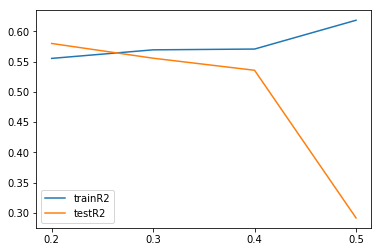

In [207]:
plt.plot(trainr2,label="trainR2")
plt.plot(testr2,label="testR2")
plt.xticks(ticks=[0,1,2,3],labels=[0.2,0.3,0.4,0.5])
plt.legend();

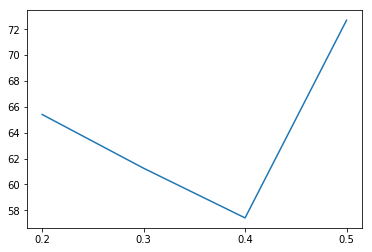

In [208]:
plt.plot(testRMSE)
plt.xticks(ticks=[0,1,2,3],labels=[0.2,0.3,0.4,0.5]);

In [209]:
testRMSE

[65.40794949571959, 61.25139186202897, 57.41019115381894, 72.69578060100807]

从结果上看，在测试集上RMSE最低的训练集数量是0.4，从R2的表现来看，测试集比例为0.4时，训练集上R2表现出过拟合的倾向，但并不严重。但考虑到现在模型的核心评估指标是RMSE，因此R2稍有问题，但RMSE明显有优势时，则优先考虑RMSE上的表现。

In [210]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.4,random_state=0)

In [211]:
Ytrain = pd.DataFrame(Ytrain)
Ytest = pd.DataFrame(Ytest)

Ytrain.index = Xtrain.index
Ytest.index = Xtest.index

In [212]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
1914412,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
188838,26375.000,4200.000,0.000,0.000,0.000,0.000,32000.000,2250.000,0.000,0.000,...,8996.154,0.000,1.493,0.000,0,0,1,0,1,0
1879427,2063.000,1350.000,0.000,0.000,0.000,0.000,1531.000,675.000,0.000,0.000,...,184.308,0.000,0.009,0.000,0,0,1,0,1,0
1616849,56314.000,17460.000,0.000,0.000,0.000,0.000,76717.000,10850.000,0.000,0.000,...,12294.005,0.000,0.997,0.000,0,0,1,0,1,0
2046255,220125.000,3700.000,200000.000,0.000,200000.000,0.000,616375.000,2000.000,60000.000,0.000,...,299367.992,0.000,2.197,0.000,0,0,1,0,1,0


#### 5.3 异常值处理

In [213]:
import warnings #消除警告的代码
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [219]:
def AbnormalReplace(Xtrain,Xtest):
    #先对所有特征进行异常检测
    #对7日内付过费的用户，不处理
    #对7日内没付过费的用户，替换所有异常值为当前特征的中位数或者0
    
    Xtrain_ = Xtrain.copy()
    Xtest_ = Xtest.copy()
    for column in Xtrain_.columns:
        #提取当前要检测的列
        f_train = Xtrain_.loc[:,column]
        f_test = Xtest_.loc[:,column]

        #从训练集中计算出QL、QU、IQR、中位数
        QL = np.quantile(f_train,0.25)
        QU = np.quantile(f_train,0.75)
        IQR = QU - QL
        medium_ = f_train.median()
        
        #对训练集和测试集同时进行检测，得到True/False列表
        errortrain = ((f_train < (QL - 1.5*IQR)).astype(int) + (f_train > (QU + 1.5*IQR)).astype(int)) != 0
        errortest = ((f_test < (QL - 1.5*IQR)).astype(int) + (f_test > (QU + 1.5*IQR)).astype(int)) != 0

        #将原矩阵中的异常值替换为中位数，主题排除7日付费用户
        #如果效果不够强烈，试试看替换为0
        Xtrain_.loc[((Xtrain_["付费金额"]==0).values & errortrain.values),column] = 0 #medium_
        Xtest_.loc[((Xtest_["付费金额"]==0).values & errortest.values),column] = 0 #medium_
        
    return Xtrain_, Xtest_

In [215]:
Xtrain["木头获取数量"].describe()

count      1372804.000
mean        459707.645
std        5253011.374
min              0.000
25%              0.000
50%          41934.000
75%         153061.750
max     1239962311.000
Name: 木头获取数量, dtype: float64

In [220]:
xtrain, xtest = AbnormalReplace(Xtrain,Xtest) #为了保留原始的Xtrain和Xtest，新生成的值写作小写

ValueError: operands could not be broadcast together with shapes (1372804,) (1372804,2) 

In [221]:
xtrain["木头获取数量"].describe() #查看处理数据确认数据变化

NameError: name 'xtrain' is not defined

#### 5.4 归一化处理

In [222]:
#加速运算，各个特征量纲统一 - 使用线性回归的时候就可以查看系数来决定特征的重要性

In [223]:
from sklearn.preprocessing import MinMaxScaler #[0,1]最常使用的基本方式，x - x.min() / x.max() - x.min()

In [224]:
mm = MinMaxScaler(feature_range = [0,1]) #实例化，[0,1]

In [225]:
mm = mm.fit(xtrain) #训练 - 生成了训练集上的最小值和最大值

NameError: name 'xtrain' is not defined

In [226]:
xtrain = mm.transform(xtrain) #使用训练集上的最小值和最大值对训练集/测试集同时进行归一化
xtest = mm.transform(xtest)

NameError: name 'xtrain' is not defined

In [237]:
xtrain.min()

0.0

In [238]:
xtrain.max()

1.0

In [239]:
xtest.min()

0.0

In [240]:
xtest.max()

1.3636363636363638

#### 5.5 正态化处理 (选做)

### 6. 模型融合：处理极度偏态的数据带来的问题

在进行异常值处理时，发现所有的氪金用户都被包括在了异常用户中，这说明有大量未氪金的用户表现在游戏资源积累、游戏参与深度上的行为与氪金用户极为相似。同时，氪金用户与不氪金用户的用户组成都相对复杂。

在氪金用户中，有进入游戏1分钟就闭眼氪0.99的羊毛玩家，也有在游戏中7日都未氪、7日后不知为何突然磕了一点点的玩家。在不氪金用户中，有深度参与游戏但一分钱不氪肝帝，又有玩得很糟但一直不退游的玩家。因此在预测前其实就可以想象到，模型在用户辨别、金额预测上的效果恐怕不会太好。

在之前的特征处理中，我们已经对异常值进行过“盖帽”处理，并在特征中增加我们认为可以让氪金和非氪金用户区别变大的特征，但直接让单一模型对氪金用户的氪金数额进行预测是非常困难的。因此，我们可以使用2个模型进行融合预测，第一个模型是分类模型逻辑回归，我们让逻辑回归先对用户进行“氪与不氪”的预测，然后将逻辑回归认为会氪的用户放入线性回归，再让线性回归直接对“本来就很可能会氪金”的用户进行氪金金额预测。这样的方式经过适当调整后，应该能够提升模型表现。

- 创造逻辑回归使用的y

In [227]:
#逻辑回归的标签：氪金(1)与不氪金(0)，1类远远少于0类

In [228]:
y2 = (y != 0).astype(int) #所有氪金用户转化为1，不氪金用户转化为0

In [229]:
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: 45日付费金额, dtype: int64

In [230]:
y2.value_counts() #45988 - 45天的时候有氪金金额的用户

0    2242019
1      45988
Name: 45日付费金额, dtype: int64

In [231]:
1 - 45988/y2.shape[0]

0.9799004111438471

In [232]:
#Xtrain,Xtest,线性回归用的Ytrain, Ytest，我有逻辑回归的y2 --> 变成可以和Xtrain、Xtest相匹配的y2train, y2test

In [233]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
1914412,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
188838,26375.000,4200.000,0.000,0.000,0.000,0.000,32000.000,2250.000,0.000,0.000,...,8996.154,0.000,1.493,0.000,0,0,1,0,1,0
1879427,2063.000,1350.000,0.000,0.000,0.000,0.000,1531.000,675.000,0.000,0.000,...,184.308,0.000,0.009,0.000,0,0,1,0,1,0
1616849,56314.000,17460.000,0.000,0.000,0.000,0.000,76717.000,10850.000,0.000,0.000,...,12294.005,0.000,0.997,0.000,0,0,1,0,1,0
2046255,220125.000,3700.000,200000.000,0.000,200000.000,0.000,616375.000,2000.000,60000.000,0.000,...,299367.992,0.000,2.197,0.000,0,0,1,0,1,0


In [234]:
Ytrain2 = y2[Xtrain.index] #以Xtrain,Xtest的分割方式来分割y2，这样y2就是与Ytrain相匹配的

In [235]:
Ytest2 = y2[Xtest.index]

In [236]:
Ytrain2.head() #注意索引与原来相对

1914412    0
188838     0
1879427    0
1616849    0
2046255    0
Name: 45日付费金额, dtype: int64

- 使用逻辑回归进行建模并使用ROC进行评估

In [237]:
from sklearn.linear_model import LogisticRegression as LogiR
from sklearn.metrics import roc_auc_score as ROC #ROC
from sklearn.metrics import recall_score as Recall #召回
from sklearn.metrics import precision_score as Precision #精确度

In [238]:
clf = LogiR(random_state=0) #逻辑回归的实例化

In [239]:
clf.fit(xtrain,Ytrain2) #训练，使用经过一切特征工程的特征矩阵xtrain

NameError: name 'xtrain' is not defined

In [256]:
clf.score(xtrain,Ytrain2) #逻辑回归在训练集上的准确率

0.9968094498559154

In [257]:
clf.score(xtest,Ytest2) #逻辑回归在测试集上的准确率

0.9968302114394293

In [262]:
#测试集的拟合情况
y2_proba = clf.predict_proba(xtest) #找出了逻辑回归在测试集上对每个样本预测的概率

In [263]:
y2_proba

array([[0.99489246, 0.00510754],
       [0.99814666, 0.00185334],
       [0.99821666, 0.00178334],
       ...,
       [0.99808411, 0.00191589],
       [0.99753833, 0.00246167],
       [0.99817061, 0.00182939]])

In [258]:
y2_proba[:,1] #提取出为1的概率

array([0.00510754, 0.00185334, 0.00178334, ..., 0.00191589, 0.00246167,
       0.00182939])

In [259]:
ROC(Ytest2,y2_proba[:,1]) #越接近1越好（越接近0越好），最糟糕的情况是接近0.5

0.9712748966963473

In [260]:
Recall(Ytest2,clf.predict(xtest))

0.8421310404875925

In [261]:
Precision(Ytest2,clf.predict(xtest))

1.0

逻辑回归的结果出乎意料地好，能够在样本不均衡如此严重的情况下达到0.98的ROC，证明该数据与逻辑回归非常适配。

- 调节阈值提升Recall

recall和precision结合起来看说明，所有被预测为1的值都预测正确了，但是还有部分被预测为0的值，实际上真正的值是1。在该recall和precision下，测试集捕捉出的1类（付费用户）数为：

In [102]:
(y2_proba[:,1] > 0.5).sum()

15771

实际付费用户数为：

In [103]:
(Ytest != 0).sum()

45日付费金额    18376
dtype: int64

也就是说，有许多氪金用户被逻辑回归分类到“不氪金”的范畴了，如果按照现在的结果建模，那RMSE的主要来源就是**没有被逻辑回归包括的氪金用户的氪金数额 + 被逻辑回归指向付费、受线性回归预测后的金额差异（状况A）**。

如果我们希望逻辑回归能够捕捉到所有真实氪金的用户，为此即便误伤一些没有氪金的用户，那我们就要努力提升Recall，此时RMSE的主要来源就是**被逻辑回归误认为是氪金用户的非氪用户在线性回归中的预测值 + 全部真实氪金用户经过线性回归预测后的金额差异（状况B）**。注意该状况下需要线性回归预测的值会更多。

为难的是，我们现在并不知道这两种状况中哪种会有整体更低的RMSE，但我们知道现状就是状况A，如果我们需要提升Recall的话就可以降低逻辑回归中用于分类的阈值。

在逻辑回归中，当预测出概率后，一般我们认为阈值是0.5，当概率大于0.5时样本的标签为1，当概率小于0.5时样本的标签为0。如果想要提升Recall，可以降低模型的阈值。然而，sklearn中的逻辑回归并不提供该功能，因此我们需要自己计算调整阈值后的Recall。来看下面的代码：

In [104]:
#找出模型之前预测的1类概率
prob = y2_proba[:,1]

In [105]:
#尝试更换阈值
(prob > 0.3).astype(int) #阈值为0.3下的预测标签

array([0, 0, 0, ..., 0, 0, 0])

In [106]:
#在0~0.5中循环20个阈值备选数，会发现阈值越低，recall越高
for tol in np.linspace(0,0.5,20):
    pred = (prob >= tol).astype(int)
    recall = Recall(Ytest2,pred)
    print("{:.3f} Recall:{:.3f}".format(tol,recall))

0.000 Recall:1.000
0.026 Recall:0.913
0.053 Recall:0.888
0.079 Recall:0.868
0.105 Recall:0.867
0.132 Recall:0.867
0.158 Recall:0.866
0.184 Recall:0.866
0.211 Recall:0.866
0.237 Recall:0.865
0.263 Recall:0.865
0.289 Recall:0.864
0.316 Recall:0.863
0.342 Recall:0.863
0.368 Recall:0.862
0.395 Recall:0.861
0.421 Recall:0.860
0.447 Recall:0.859
0.474 Recall:0.859
0.500 Recall:0.858


In [107]:
for tol in np.linspace(0,0.026,20): #在0~0.026之间再选择一个更小的阈值
    pred = (prob >= tol).astype(int)
    recall = Recall(Ytest2,pred)
    print("{:.3f} Recall:{:.3f}".format(tol,recall))

0.000 Recall:1.000
0.014 Recall:0.936
0.027 Recall:0.913
0.041 Recall:0.902
0.055 Recall:0.885
0.068 Recall:0.871
0.082 Recall:0.868
0.096 Recall:0.867
0.109 Recall:0.867
0.123 Recall:0.867
0.137 Recall:0.867
0.151 Recall:0.866
0.164 Recall:0.866
0.178 Recall:0.866
0.192 Recall:0.866
0.205 Recall:0.866
0.219 Recall:0.865
0.233 Recall:0.865
0.246 Recall:0.865
0.260 Recall:0.865


In [108]:
#预设阈值
#现状：0.5
#可能的让recall升高并且降低RMSE的值：尝试0.026
#可能让recall升高但或许会误伤太多0类导致RMSE升高的值：尝试0.014

tol_ = 0.02 #多次实验之后，确认了阈值0.02可能是一个比较合适的值

In [109]:
#在0.02阈值下，逻辑回归预测了测试集中的多少样本为1
(y2_proba[:,1] >= tol_).sum()

38184

In [110]:
#训练集中的多少样本被预测为1
(clf.predict_proba(xtrain)[:,1] >= tol_).sum()

57165

以上就是需要带入线性回归进行建模的数据量。

- 保留逻辑回归按阈值为0.02时的预测结果

In [111]:
#对于所有不氪金的样本而言，预测已经到此结束了 - 标签y为0
#测试集，千万别忘记将Xtest的索引导入
result = pd.DataFrame(y2_proba[:,1],index=Xtest.index)
result.columns = ["logi_proba"]
result["logi_y_pred"] = (result["logi_proba"] >= tol_).astype(int)

In [112]:
result.head()

,logi_proba,logi_y_pred
660869,0.001033,0
1002543,0.001454,0
2044898,0.001400,0
961802,0.001083,0
793236,0.001191,0


In [113]:
#训练集，同样索引需要导入
logi_train_result = pd.DataFrame(clf.predict_proba(xtrain)[:,1],index=Xtrain.index)
logi_train_result.columns = ["logi_train_proba"]
logi_train_result["logi_y_pred_train"] = (logi_train_result["logi_train_proba"] >= tol_).astype(int)

In [114]:
logi_train_result.head()

,logi_train_proba,logi_y_pred_train
1914412,0.001444,0
188838,0.001325,0
1879427,0.001293,0
1616849,0.001350,0
2046255,0.001498,0


- 选出应该放出线性回归中的训练集与测试集

In [115]:
#训练集：逻辑回归的预测标签为1的部分
xtrain_linear_reg = xtrain[logi_train_result["logi_y_pred_train"] == 1]
ytrain_linear_reg = Ytrain[logi_train_result["logi_y_pred_train"] == 1]

In [116]:
xtrain_linear_reg.shape #确认与训练集中被预测为1的样本数一致

(57165, 119)

In [117]:
#测试集
xtest_linear_reg = xtest[result["logi_y_pred"] == 1]
ytest_linear_reg = Ytest[result["logi_y_pred"] == 1]

In [118]:
xtest_linear_reg.shape

(38184, 119)

- 开始回归预测

In [119]:
def reg_predict(model):
    reg = model.fit(xtrain_linear_reg, ytrain_linear_reg) #训练
    y_linear_pred = reg.predict(xtest_linear_reg) #对测试集进行预测
    print("训练集R2:{:.3f}".format(reg.score(xtrain_linear_reg, ytrain_linear_reg)))
    print("测试集R2:{:.3f}".format(reg.score(xtest_linear_reg, ytest_linear_reg)))
    print("测试集RMSE:{:.3f}".format(np.sqrt(MSE(ytest_linear_reg,y_linear_pred))))
    return y_linear_pred #融合模型预测出的结果中的 - 回归部分

In [120]:
#线性回归
reg0 = LR()

In [121]:
y_linear_pred0 = reg_predict(reg0) #没有什么参数可以调整的

训练集R2:0.582
测试集R2:0.538
测试集RMSE:277.579


In [122]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [123]:
reg1 = RFR(n_estimators=100,max_depth=2,max_features=20,random_state=1412)
reg2 = GBR(n_estimators=100,max_depth=2,max_features=20,random_state=1412)

In [124]:
y_linear_pred1 = reg_predict(reg1) #随机森林这个算法就是不太适合现在的数据

训练集R2:0.521
测试集R2:0.430
测试集RMSE:308.283


In [125]:
y_linear_pred2 = reg_predict(reg2)

训练集R2:0.735
测试集R2:0.533
测试集RMSE:279.156


### 7. 模型调优

In [265]:
#学习曲线、交叉验证、网格搜索 - 通通靠边

- 经验调参

In [126]:
reg2 = GBR(n_estimators = 490 #首先考虑的是增大模型的树的数量，来提升整体拟合能力
           ,max_depth= 2 #但又很容易过拟合，因此控制住树的深度
           ,learning_rate= 0.05 #当n_estimators和max_depth调不出好结果时，有限考虑降低学习率，学习率对树模型的效果影响很大
           ,max_features = 50 #max_features的存在一开始主要是为了控制建模速度的，但是也可以控制过拟合，可以使用学习曲线找适合的阶段和位置
           ,min_samples_split = 25 #如果模型仍然过拟合，可以试着增加min_samples_split，增大允许分叶子的样本数量，以此来减少树的拟合程度
           ,random_state= 1412)

In [127]:
y_linear_pred2 = reg_predict(reg2)

训练集R2:0.795
测试集R2:0.586
测试集RMSE:262.749


- 将线性回归与逻辑回归的预测值合并

In [128]:
result["reg_result"] = 0 #创建新列，全部为0

In [129]:
#将逻辑回归的预测标签为1的样本提出来，对所有这些样本的“reg_result”回归结果列填入回归的预测结果y_linear_pred
result.loc[result["logi_y_pred"] == 1,"reg_result"] = y_linear_pred2

In [130]:
result.head()

,logi_proba,logi_y_pred,reg_result
660869,0.001033,0,0.0
1002543,0.001454,0,0.0
2044898,0.001400,0,0.0
961802,0.001083,0,0.0
793236,0.001191,0,0.0


In [131]:
Ytest.head() #确认索引一致

,45日付费金额
660869,0.0
1002543,0.0
2044898,0.0
961802,0.0
793236,0.0


In [132]:
np.sqrt(MSE(Ytest,result["reg_result"]))

54.422094868663

In [144]:
FeatureImportance = pd.concat([pd.DataFrame(Xtrain.columns),pd.DataFrame(reg2.feature_importances_)],axis=1)

In [147]:
FeatureImportance.sort_values(0,ascending=False) #特征重要性

,字段解释,0
104,付费金额,0.249891
105,付费次数,0.083299
28,训练加速获取数量,0.068863
4,象牙获取数量,0.066772
23,通用加速使用数量,0.062143
...,...,...
82,科研：魔法采集,0.000000
85,科研：据点二,0.000000
57,科研：高阶巨兽骑兵,0.000000
94,科研：增援部队容量,0.000000


- **改进空间**
> 1. 使用聚合方式创造特征
> 2. 使用分箱处理连续型特征（对线性回归有异常好的效果）
> 3. 更换更强大的算法（如神经网络/LGBM）